<div style="background: linear-gradient(135deg, #f0f0ff 0%, #fff 50%, #f5f0ff 100%); padding: 40px; border-radius: 20px; text-align: center; margin: 20px 0;">
    <div style="width: 60px; height: 3px; background: linear-gradient(135deg, #667eea, #764ba2); margin: 0 auto 20px; border-radius: 2px;"></div>
    <h1 style="font-family: Georgia, serif; font-size: 2.2rem; margin: 0 0 10px; font-weight: 700;">
        Does Sephora's Exclusivity Strategy 
        <span style="background: linear-gradient(135deg, #667eea, #764ba2); -webkit-background-clip: text; -webkit-text-fill-color: transparent; font-weight: 700;">Drive Customer Engagement?</span>
    </h1>
</div>

## ![Only at Sephora](https://img.grouponcdn.com/seocms/282jXDncjUbW7ZMwAnLRE7WmPGMk/2021-08_ContentPush-SephoraExclusive_hero_jpg-1524x700/v1/c1524x700)

## **TABLE OF CONTENTS**

0. Notebook Preparation
1. Preface
   - 1.1 Introduction & research question
   - 1.2 Approach
   - 1.3 Data used
2. Data loading & preparation
   - 2.1 Product data
   - 2.2 Reviews data
3. Exploratory data analysis
   - 3.1 Product data
   - 3.2 Reviews data
4. Modelling
   - 4.1 OLS Regression: Does exclusivity drive engagement?
   - 4.2 Logistic Regression: What predicts exclusivity?
5. Sentiment analysis
   - 5.1 Do exclusive products receive longer, more detailed reviews?
   - 5.2 Are reviews for exclusive products more positive?
   - 5.3 Do customers use different emotional language for exclusives?
6. Clustering
7. Conclusion
8. References

#### ⚠️ Before running this notebook ensure you have the following:

1. **Required packages** (if needed): Uncomment and run `!pip install kaggle`, and `!pip install textblob` under **0. NOTEBOOK PREPARATION** cell
2. **styles.py**: make sure it is saved in the same folder as this notebook. The notebook won't run without it.
3. **Kaggle account**: Sign up at [kaggle.com](https://www.kaggle.com) if you don't have one.
4. **Kaggle API key**: Go to [kaggle.com](https://www.kaggle.com) -> Profile (top right) -> Account -> Settings -> Scroll to "API" -> Click "Generate New Token". Then add your credentials:
- In Section 2 (Data Loading), find the Kaggle authentication cell
- Replace `'your_username_here'` with your Kaggle username
- Replace `'your_api_key_here'` with the key from your step 1

Once setup is complete, you can run all cells sequentially.

## **0. NOTEBOOK PREPARATION**

In [ ]:
# Uncomment if not installed
# !pip install textblob
# !{sys.executable} -m pip install kaggle or pip install kaggle
# !{sys.executable} -m pip install wordcloud or pip install wordcloud

# === IMPORTS ===
import sys
from pathlib import Path
from wordcloud import WordCloud

import numpy as np
import pandas as pd
from glob import glob
import os
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML, display

from scipy import stats

import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob
import re
from collections import Counter

import importlib
import styles
importlib.reload(styles)

from styles import (
    COLORS, CUSTOM_CMAP, EXCL_COLORS,
    style_axis, styled_boxplot, prepare_exclusive, format_pval,
    styled_table, styled_shape, styled_missing, styled_ttest_table,
    styled_engagement_stats, styled_price_stats,
    styled_cluster_summary, styled_cluster_exclusivity, styled_note,
    styled_ols_result, styled_sentiment_summary,
    EMOTION_WHITELIST, POSITIVE_WORDS, NEGATIVE_WORDS,
    extract_emotions, get_sentiment, create_figure, styled_brand_stats
)

## **1. PREFACE**

#### 1.1 Introduction and research question

When Rare Beauty by Selena Gomez launched on September 3, 2020, exclusively through its official website and Sephora stores in North America, it became one of the most viral beauty brands in the category (~$350M in annual sales by 2023) crossing ~$400M by early 2024 ([Business of Fashion, 2024](https://www.businessoffashion.com/articles/beauty/selena-gomezs-rare-beauty-exploring-an-ipo-or-sale-as-revenue-crosses-400-million/)). Similarly, when Hailey Bieber's Rhode debuted at Sephora on September 4, 2025, it became Sephora's largest brand launch in North American history exceeding ~$10M in retail sales within the first two days and accounting for ~40% of Sephora's total online sales on launch day ([WWD, 2025](https://wwd.com/beauty-industry-news/beauty-features/hailey-bieber-rhode-sephora-launch-sales-performance-1238203945/)).

These reflect a core competitive strategy for Sephora known as <span style="color: #7B2D8E; font-weight: bold;">**product exclusivity**</span>. ~50% of products sold at Sephora cannot be purchased elsewhere ([Motte, 2025](https://beautymatter.com/articles/sephora-bets-on-brand-exclusivity-and-experience-to-power-global-push)), and this exclusivity operates through three mechanisms:

1. Exclusive brand partnerships — brands agree to sell only through Sephora (e.g., Merit Beauty, Rhode, Dr. Sam's) ([Sephora UK Exclusives](https://www.sephora.co.uk/exclusives))
2. First-to-market launches — new products debut at Sephora before wider distribution (e.g., Rare Beauty, Fenty Beauty)
3. Private label — Sephora Collection products available nowhere else

This strategy creates a prestige positioning that differentiates Sephora from drugstore retailers like CVS or Walgreens, and it generates "beauty FOMO (Fear of Missing Out)"—customers know that exclusive products may not be available elsewhere, driving urgency to purchase. Industry research suggests exclusive product launches generate significantly higher engagement, with one campaign reporting 224% above-average social media interaction ([CB Insights, 2021](https://www.cbinsights.com/research/report/sephora-teardown/)).

We are therefore interested in testing the following research question:

> **Do exclusive products systematically outperform non-exclusive products in customer engagement?**

#### 1.2 Approach

To answer this question, we use two datasets from Kaggle containing **8,494 products** and **~1M customer reviews** from Sephora's US catalog and do the following:

- We begin with **exploratory data analysis** to understand Sephora's catalog composition and customer behaviour. For products, we examine category distribution, the proportion of exclusives overall and by category, brand-level patterns, and compare engagement metrics (loves, reviews, ratings) between exclusive and non-exclusive products. We also analyse price distributions and correlations between key variables. For reviews, we investigate volume per product and temporal patterns, noting that exclusive products only began appearing around 2017

- We conduct **regression modelling** to identify what drives customer engagement. Using OLS regression with `loves_count` as our target, we test whether exclusivity remains a significant predictor after controlling for price, rating, reviews, product flags, and category. We then use logistic regression to examine the reverse question: what product characteristics predict whether a product is exclusive?

- We perform **sentiment analysis** on review text to understand how customers feel about products, and whether exclusive products generate more positive feedback than non-exclusives

- Finally, we apply **clustering algorithms** to segment products based on their engagement profiles, allowing us to identify distinct product archetypes and examine whether exclusive products are overrepresented in high-performing clusters

#### 1.3 Data used

Our analysis uses ***two*** datasets from Kaggle's **"Sephora Products and Skincare Reviews"** published by [nadyinky](https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews). The data provides comprehensive product metadata including the `sephora_exclusive` flag essential to our research question, paired with ~1M customer reviews enabling engagement analysis. The dataset was scraped directly from Sephora's US website, ensuring authenticity and relevance to real consumer behaviour. 

The data has 2 files:
a) Product Catalog (`product_info.csv`): A catalog of **8,494 products** from Sephora's US website containing the following variables:
b) Customer Reviews (`reviews_0-250.csv` to `reviews_1250-end.csv`): ~**1M reviews** split across five CSV files, containing the following variables:

<div style="display: flex; gap: 30px;">

<div>

**Products Dataset**

| Feature | Description |
|---------|-------------|
| `product_id` | Unique identifier for the product |
| `product_name` | Full name of the product |
| `brand_id` | Unique identifier for the product brand |
| `brand_name` | Full name of the product brand |
| `loves_count` | Number of people who marked this product as a favourite |
| `rating` | Average rating based on user reviews |
| `reviews` | Number of user reviews for the product |
| `size` | Size of the product (oz, ml, g, packs, etc.) |
| `variation_type` | Type of variation parameter (e.g., Size, Color) |
| `variation_value` | Specific value of the variation (e.g., 100 mL, Golden Sand) |
| `variation_desc` | Description of the variation parameter |
| `ingredients` | List of ingredients included in the product |
| `price_usd` | Price of the product in US dollars |
| `value_price_usd` | Potential cost savings, shown next to regular price |
| `sale_price_usd` | Sale price of the product in US dollars |
| `limited_edition` | Whether the product is limited edition (1=true, 0=false) |
| `new` | Whether the product is new (1=true, 0=false) |
| `online_only` | Whether the product is only sold online (1=true, 0=false) |
| `out_of_stock` | Whether the product is currently out of stock (1=true, 0=false) |
| `sephora_exclusive` | Whether the product is exclusive to Sephora (1=true, 0=false) |
| `highlights` | Tags or features highlighting product attributes (e.g., 'Vegan', 'Matte Finish') |
| `primary_category` | First category in the breadcrumb section |
| `secondary_category` | Second category in the breadcrumb section |
| `tertiary_category` | Third category in the breadcrumb section |
| `child_count` | Number of variations of the product available |
| `child_max_price` | Highest price among variations |
| `child_min_price` | Lowest price among variations |

</div>

<div>

**Reviews Dataset**

| Feature | Description |
|---------|-------------|
| `author_id` | Unique identifier for the review author |
| `rating` | Rating given by the author (1-5 scale) |
| `is_recommended` | Whether the author recommends the product (1=true, 0=false) |
| `helpfulness` | Ratio of positive to total feedback ratings for the review |
| `total_feedback_count` | Total number of feedback (positive and negative) left by users |
| `total_neg_feedback_count` | Number of users who gave a negative rating for the review |
| `total_pos_feedback_count` | Number of users who gave a positive rating for the review |
| `submission_time` | Date the review was posted ('yyyy-mm-dd' format) |
| `review_text` | Main text of the review |
| `review_title` | Title of the review |
| `skin_tone` | Author's skin tone (e.g., fair, tan, etc.) |
| `eye_color` | Author's eye color (e.g., brown, green, etc.) |
| `skin_type` | Author's skin type (e.g., combination, oily, etc.) |
| `hair_color` | Author's hair color (e.g., brown, auburn, etc.) |
| `product_id` | Product identifier (links to product catalog) |

</div>

</div>

## **2. DATA LOADING AND PREPARATION**

#### 2.0: Data scraping

In [68]:
# REQUIRED:
# Get your Kaggle API credentials:
# Go to kaggle.com -> Account -> Settings -> API -> Generate new token

os.environ['KAGGLE_USERNAME'] = 'your_username_here'
os.environ['KAGGLE_KEY'] = 'your_api_key_here'

try:
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()
    
    api.dataset_download_files(
        'nadyinky/sephora-products-and-skincare-reviews',
        path='./data',
        unzip=True
    )
    print("Dataset downloaded successfully to ./data/")
    
except ModuleNotFoundError:
    print("ERROR: kaggle module not installed.")
    print("Run: !{sys.executable} -m pip install kaggle")
    
except Exception as e:
    if "401" in str(e) or "Could not authenticate" in str(e).lower():
        print("ERROR: Authentication failed.")
        print("1. Go to kaggle.com -> Account -> Settings -> API -> Generate new token")
        print("2. Replace 'your_username_here' and 'your_api_key_here' above with your credentials")
    else:
        print(f"ERROR: {e}")
        print("Check your Kaggle credentials.")

Dataset URL: https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews
Dataset downloaded successfully to ./data/


#### 2.1: Product data

In [69]:
DATA_PATH = Path('./data/product_info.csv')

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Could not find {DATA_PATH}.")

product_raw = pd.read_csv(DATA_PATH)

In [70]:
styled_shape(product_raw)
styled_table(
    product_raw.head(5),
    caption='Product Data Preview (first 5 rows)',
    mode='preview',
    max_colwidth=60
)

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,variation_desc,ingredients,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,"6,342",19-69,"6,320",3.636,11.000,nan,nan,nan,nan,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD Alcohol 39C), ...",35.000,nan,nan,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scent', 'Woody & ...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,nan,nan
1,P473668,La Habana Eau de Parfum,"6,342",19-69,"3,827",4.154,13.000,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,nan,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Ethyl...",195.000,nan,nan,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent', 'Warm &Spic...",Fragrance,Women,Perfume,2,85.000,30.000
2,P473662,Rainbow Bar Eau de Parfum,"6,342",19-69,"3,253",4.250,16.000,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,nan,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) D-Lim...",195.000,nan,nan,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent', 'Woody & Ea...",Fragrance,Women,Perfume,2,75.000,30.000
3,P473660,Kasbah Eau de Parfum,"6,342",19-69,"3,018",4.476,21.000,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,nan,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Couma...",195.000,nan,nan,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent', 'Warm &Spic...",Fragrance,Women,Perfume,2,75.000,30.000
4,P473658,Purple Haze Eau de Parfum,"6,342",19-69,"2,691",3.231,13.000,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,nan,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Octox...",195.000,nan,nan,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent', 'Woody & Ea...",Fragrance,Women,Perfume,2,75.000,30.000


In [71]:
styled_missing(product_raw)

Column,Data Type,Missing,Percent
sale_price_usd,float64,"8,224",96.8%
value_price_usd,float64,"8,043",94.7%
variation_desc,object,"7,244",85.3%
child_max_price,float64,"5,740",67.6%
child_min_price,float64,"5,740",67.6%
highlights,object,"2,207",26.0%
size,object,"1,631",19.2%
variation_value,object,"1,598",18.8%
variation_type,object,"1,444",17.0%
tertiary_category,object,990,11.7%


In [72]:
# Data cleaning
product_df = product_raw.copy()

keep_cols = [
    'product_id', 'product_name', 'primary_category', 'price_usd', 'rating', 'reviews', 'loves_count',
    'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'brand_name'
]

missing_cols = [c for c in keep_cols if c not in product_df.columns]
if missing_cols:
    print('Missing expected columns:', missing_cols)

product_df = product_df[[c for c in keep_cols if c in product_df.columns]].copy()

# Convert boolean-like flags
flag_cols = ['limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive']
for c in flag_cols:
    if c in product_df.columns:
        product_df[c] = product_df[c].astype(bool)

# Convert numeric columns
for c in ['price_usd', 'rating', 'reviews', 'loves_count']:
    if c in product_df.columns:
        product_df[c] = pd.to_numeric(product_df[c], errors='coerce')

# Drop rows missing core engagement fields
core_cols = ['price_usd', 'rating', 'reviews', 'loves_count', 'sephora_exclusive', 'primary_category']
product_df = product_df.dropna(subset=core_cols).copy()

product_df['log_loves'] = np.log1p(product_df['loves_count'])
product_df['log_reviews'] = np.log1p(product_df['reviews'])
product_df['log_price'] = np.log1p(product_df['price_usd'])

print("Cleaned data:")
styled_shape(product_df)
styled_table(product_df.head(5), caption='Cleaned Product Data Preview (first 5 rows)', mode='preview', max_colwidth=60)

Cleaned data:


,product_id,product_name,primary_category,price_usd,rating,reviews,loves_count,limited_edition,new,online_only,out_of_stock,sephora_exclusive,brand_name,log_loves,log_reviews,log_price
0,P473671,Fragrance Discovery Set,Fragrance,35.000,3.636,11.000,"6,320",False,False,True,False,False,19-69,8.752,2.485,3.584
1,P473668,La Habana Eau de Parfum,Fragrance,195.000,4.154,13.000,"3,827",False,False,True,False,False,19-69,8.250,2.639,5.278
2,P473662,Rainbow Bar Eau de Parfum,Fragrance,195.000,4.250,16.000,"3,253",False,False,True,False,False,19-69,8.088,2.833,5.278
3,P473660,Kasbah Eau de Parfum,Fragrance,195.000,4.476,21.000,"3,018",False,False,True,False,False,19-69,8.013,3.091,5.278
4,P473658,Purple Haze Eau de Parfum,Fragrance,195.000,3.231,13.000,"2,691",False,False,True,False,False,19-69,7.898,2.639,5.278


Observations

- Dataset contains 8,494 rows and 27 variables, providing a sufficiently large sample for meaningful statistical analysis. We retained 12 variables and dropped 15 columns

- Key variables for our analysis are well-populated. Our primary independent variable `sephora_exclusive` has 0% missing values. Engagement metrics (`loves_count`, `rating`, `reviews`) have <4% missing, and important controls (`price_usd`, `primary_category`) are complete.

- We converted boolean flags (`limited_edition`, `new`, `online_only`, `out_of_stock`, `sephora_exclusive`) to True/False, and numeric columns (`price_usd`, `rating`, `reviews`, `loves_count`) to numeric types

- Rows missing any core analysis variable were dropped to ensure complete cases.

- Since `loves_count`, `reviews`, and `price_usd` are heavily right-skewed (a few viral products dominate), we applied log transformations (`log1p`) to normalise their distributions

#### 2.2 Review data

In [73]:
review_files = sorted(glob('./data/reviews_*.csv'))
if len(review_files) == 0:
    review_files = sorted(glob('reviews_*.csv'))
if len(review_files) == 0:
    print('No review files found (expected reviews_*.csv).')
else:
    reviews_raw = pd.concat([pd.read_csv(f) for f in review_files], ignore_index=True)
    print('Loaded review files:', len(review_files))
    styled_shape(reviews_raw)
    display(styled_table(reviews_raw.head(5), caption='Preview: raw (first 5 rows)', mode='preview', max_colwidth=60))
    styled_missing(reviews_raw)

Loaded review files: 5


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,"1,741,593,524",5,1.000,1.000,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Balm & Make-Up M...,Taught me how to double cleanse!,nan,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.000
1,1,"31,423,088,263",1,0.000,nan,0,0,0,2023-03-21,I bought this lip mask after reading the reviews and the hy...,Disappointed,nan,nan,nan,nan,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.000
2,2,"5,061,282,401",5,1.000,nan,0,0,0,2023-03-21,My review title says it all! I get so excited to get into b...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.000
3,3,"6,083,038,851",5,1.000,nan,0,0,0,2023-03-20,I’ve always loved this formula for a long time. I honestly ...,Can't go wrong with any of them,nan,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.000
4,4,"47,056,667,835",5,1.000,nan,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must have. After a ...",A must have !!!,light,hazel,combination,nan,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.000


Column,Data Type,Missing,Percent
helpfulness,float64,"561,592",51.3%
review_title,object,"310,654",28.4%
hair_color,object,"226,768",20.7%
eye_color,object,"209,628",19.2%
skin_tone,object,"170,539",15.6%
is_recommended,float64,"167,988",15.3%
skin_type,object,"111,557",10.2%
review_text,object,"1,444",0.1%
rating,int64,0,0.0%
Unnamed: 0,int64,0,0.0%


In [74]:
# Reviews data cleaning
reviews_df = reviews_raw.copy()

drop_cols = ['helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count']
reviews_df = reviews_df.drop(columns=[c for c in drop_cols if c in reviews_df.columns])

# Add sephora_exclusive from product df
reviews_df = reviews_df.merge(product_df[['product_id', 'sephora_exclusive']], on='product_id', how='left')

print("Cleaned reviews data:")
styled_shape(reviews_df)
display(styled_table(reviews_df.head(5), caption='Cleaned Reviews Preview (first 5 rows)', mode='preview', max_colwidth=60))

Cleaned reviews data:


,Unnamed: 0,author_id,rating,is_recommended,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd,sephora_exclusive
0,0,"1,741,593,524",5,1.000,2023-02-01,I use this with the Nudestix “Citrus Clean Balm & Make-Up M...,Taught me how to double cleanse!,nan,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.000,False
1,1,"31,423,088,263",1,0.000,2023-03-21,I bought this lip mask after reading the reviews and the hy...,Disappointed,nan,nan,nan,nan,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.000,True
2,2,"5,061,282,401",5,1.000,2023-03-21,My review title says it all! I get so excited to get into b...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.000,True
3,3,"6,083,038,851",5,1.000,2023-03-20,I’ve always loved this formula for a long time. I honestly ...,Can't go wrong with any of them,nan,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.000,True
4,4,"47,056,667,835",5,1.000,2023-03-20,"If you have dry cracked lips, this is a must have. After a ...",A must have !!!,light,hazel,combination,nan,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.000,True


Observations
- The reviews dataset contains >1M rows, each representing an individual customer review. We removed four columns with high missingness / limited analytical value: `helpfulness` (51.3% missing), `total_feedback_count`, `total_neg_feedback_count`, and `total_pos_feedback_count`

- We retained `review_text` as our key variable needed for sentiment analysis. We also kept product identifiers (`product_id`, `product_name`, `brand_name`, `price_usd`) for convenience in downstream analysis

- Since the original reviews dataset does not include exclusivity information, we merged `sephora_exclusive` from the cleaned product dataframe using `product_id` as the key to compare review characteristics between exclusive and non-exclusive products directly within the reviews dataframe.

## **3. EXPLORATORY DATA ANALYSIS (EDA)**

#### 3.1 Product data

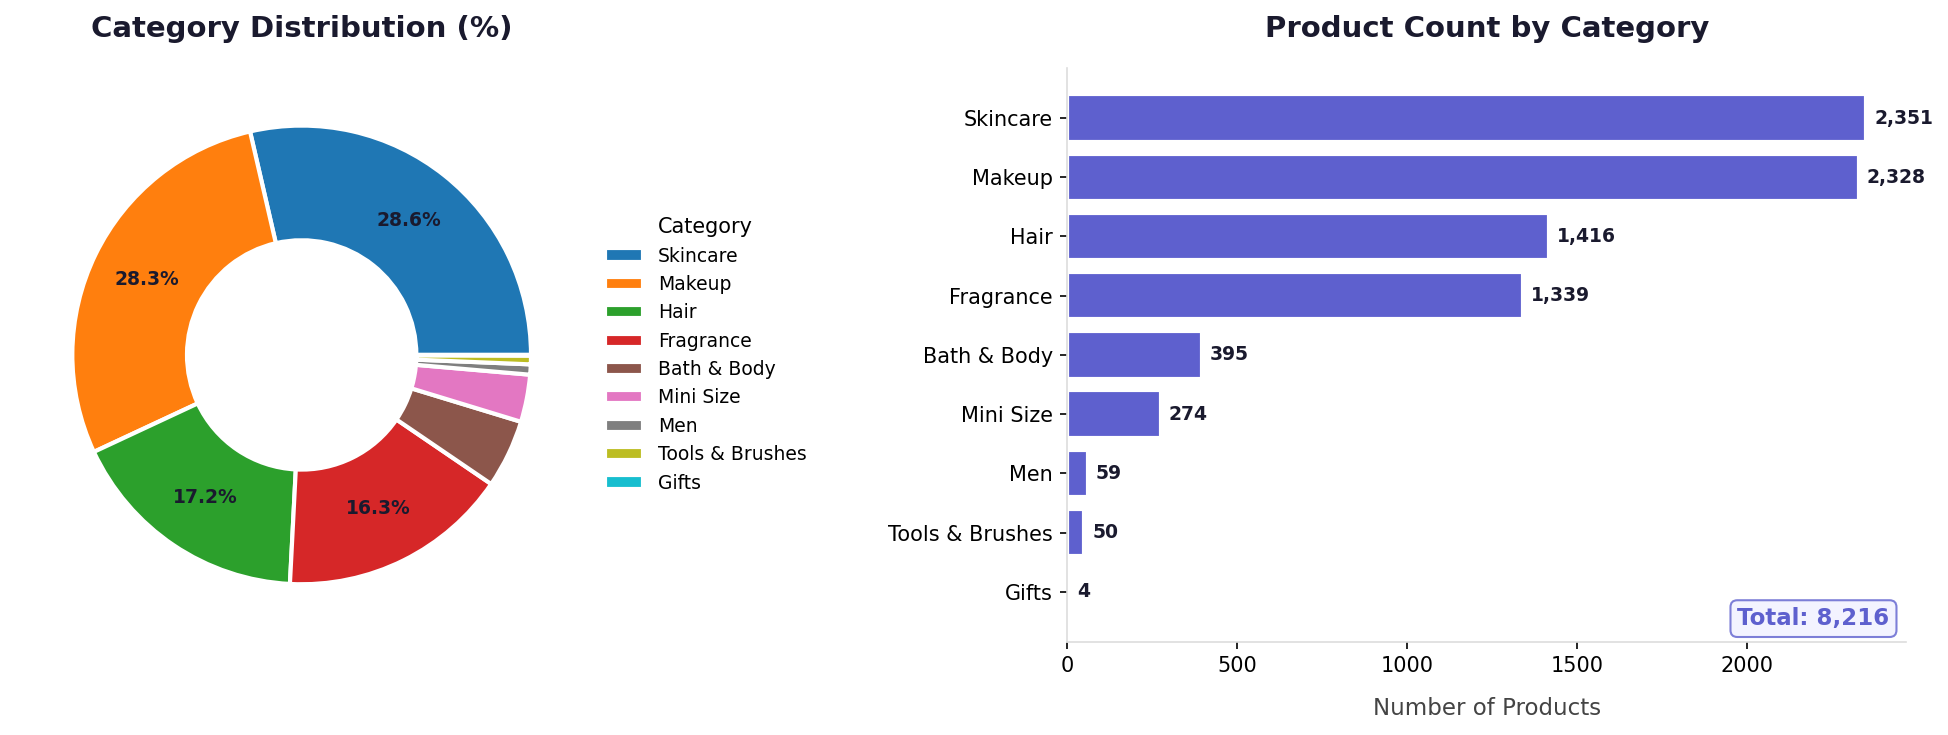

In [75]:
# What does Sephora sell

fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor='#ffffff', dpi=150)
for ax in axes:
    ax.set_facecolor('#ffffff')

cat_counts = product_df['primary_category'].value_counts()
total = cat_counts.sum()

n_cats = len(cat_counts)
pie_colors = plt.cm.Set2(np.linspace(0, 1, n_cats))

# Left: Donut chart
pie_colors = plt.cm.tab10(np.linspace(0, 1, n_cats))

wedges, texts, autotexts = axes[0].pie(
    cat_counts.values,
    labels=[''] * len(cat_counts),  # Remove direct labels
    autopct=lambda pct: f'{pct:.1f}%' if pct >= 5 else '',  # Hide small percentages
    colors=pie_colors,
    pctdistance=0.75,
    wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2)
)
for autotext in autotexts:
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')
    autotext.set_color('#1a1a2e')

axes[0].legend(wedges, cat_counts.index, title='Category', loc='center left', 
               bbox_to_anchor=(1, 0.5), fontsize=9, frameon=False)
axes[0].set_title('Category Distribution (%)', fontsize=14, fontweight='bold', color='#1a1a2e', pad=15)

# Right: Horizontal bar chart
cat_sorted = cat_counts.sort_values(ascending=True)

bars = axes[1].barh(cat_sorted.index, cat_sorted.values, color='#5E60CE', edgecolor='white', linewidth=2)

for bar in bars:
    w = bar.get_width()
    axes[1].text(w + max(cat_sorted.values)*0.01, bar.get_y() + bar.get_height()/2,
                 f"{int(w):,}", va='center', ha='left',
                 fontsize=9, fontweight='bold', color='#1a1a2e')

axes[1].text(0.98, 0.02, f"Total: {total:,}", transform=axes[1].transAxes,
             fontsize=11, fontweight='bold', color='#5E60CE',
             ha='right', va='bottom',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='#f0f0ff', edgecolor='#5E60CE', alpha=0.8))

style_axis(axes[1], title='Product Count by Category', xlabel='Number of Products', ylabel='')

plt.tight_layout()
plt.show()

Skincare and Makeup dominate the portfolio at 28.6% and 28.3% respectively, together accounting for >50% of all products. Hair (17.2%) and Fragrance (16.3%) form the second tier

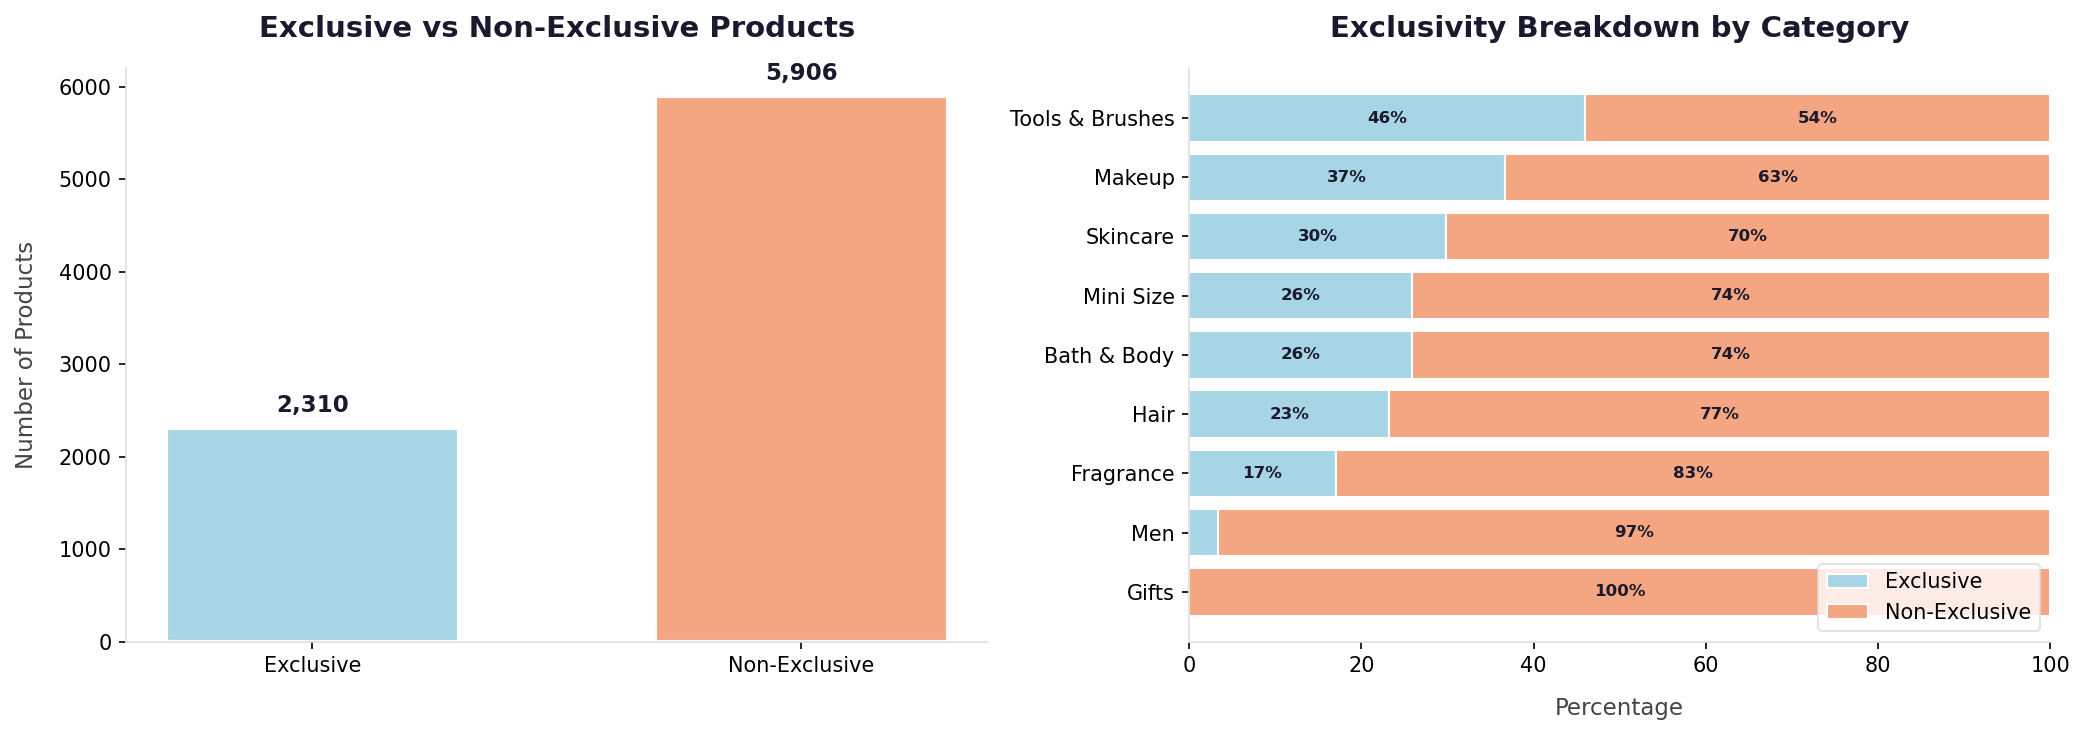

In [76]:
# PROPORTION OF EXCLUSIVE PRODUCTS

fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor='#ffffff', dpi=150)
for ax in axes:
    ax.set_facecolor('#ffffff')

# Left: Bar chart of total exclusive vs non-exclusive
excl_counts = product_df['sephora_exclusive'].value_counts()
excl_labels = ['Exclusive', 'Non-Exclusive']
excl_values = [excl_counts.get(True, 0), excl_counts.get(False, 0)]
bar_colors = [EXCL_COLORS[1], EXCL_COLORS[0]]  # Exclusive first, then Non-Exclusive

bars = axes[0].bar(excl_labels, excl_values, color=bar_colors, edgecolor='white', linewidth=2, width=0.6)

for bar in bars:
    h = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, h + max(excl_values)*0.02, f"{int(h):,}", ha='center', va='bottom', fontsize=11, fontweight='bold', color='#1a1a2e')

style_axis(axes[0], title='Exclusive vs Non-Exclusive Products', xlabel='', ylabel='Number of Products')

# Right: 100% stacked bar chart by category
excl_by_cat = product_df.groupby(['primary_category', 'sephora_exclusive']).size().unstack(fill_value=0)
excl_by_cat_pct = excl_by_cat.div(excl_by_cat.sum(axis=1), axis=0) * 100
excl_by_cat_pct = excl_by_cat_pct.sort_values(by=True, ascending=True)

y_pos = range(len(excl_by_cat_pct))
excl_pct = excl_by_cat_pct[True].values
non_excl_pct = excl_by_cat_pct[False].values

axes[1].barh(y_pos, excl_pct, color=EXCL_COLORS[1], edgecolor='white', linewidth=1, label='Exclusive')
axes[1].barh(y_pos, non_excl_pct, left=excl_pct, color=EXCL_COLORS[0], edgecolor='white', linewidth=1, label='Non-Exclusive')

axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(excl_by_cat_pct.index)
axes[1].set_xlim(0, 100)
axes[1].legend(loc='lower right', frameon=True, facecolor='white', edgecolor='#ddd')

for i, (ex, ne) in enumerate(zip(excl_pct, non_excl_pct)):
    if ex > 10:
        axes[1].text(ex/2, i, f"{ex:.0f}%", ha='center', va='center', fontsize=8, fontweight='bold', color='#1a1a2e')
    if ne > 10:
        axes[1].text(ex + ne/2, i, f"{ne:.0f}%", ha='center', va='center', fontsize=8, fontweight='bold', color='#1a1a2e')

style_axis(axes[1], title='Exclusivity Breakdown by Category', xlabel='Percentage', ylabel='')

plt.tight_layout()
plt.show()

~28% of products are Sephora exclusives. Exclusivity rates vary substantially by category: Tools & Brushes leads at 46%, followed by Makeup (37%) and Skincare (30%), while Fragrance (17%), Men (3%), and Gifts (0%) have minimal exclusive offerings. This uneven distribution suggests Sephora's exclusivity strategy is category-specific, but we cannot yet determine whether exclusives perform differently. To understand this, we examine engagement metrics next.

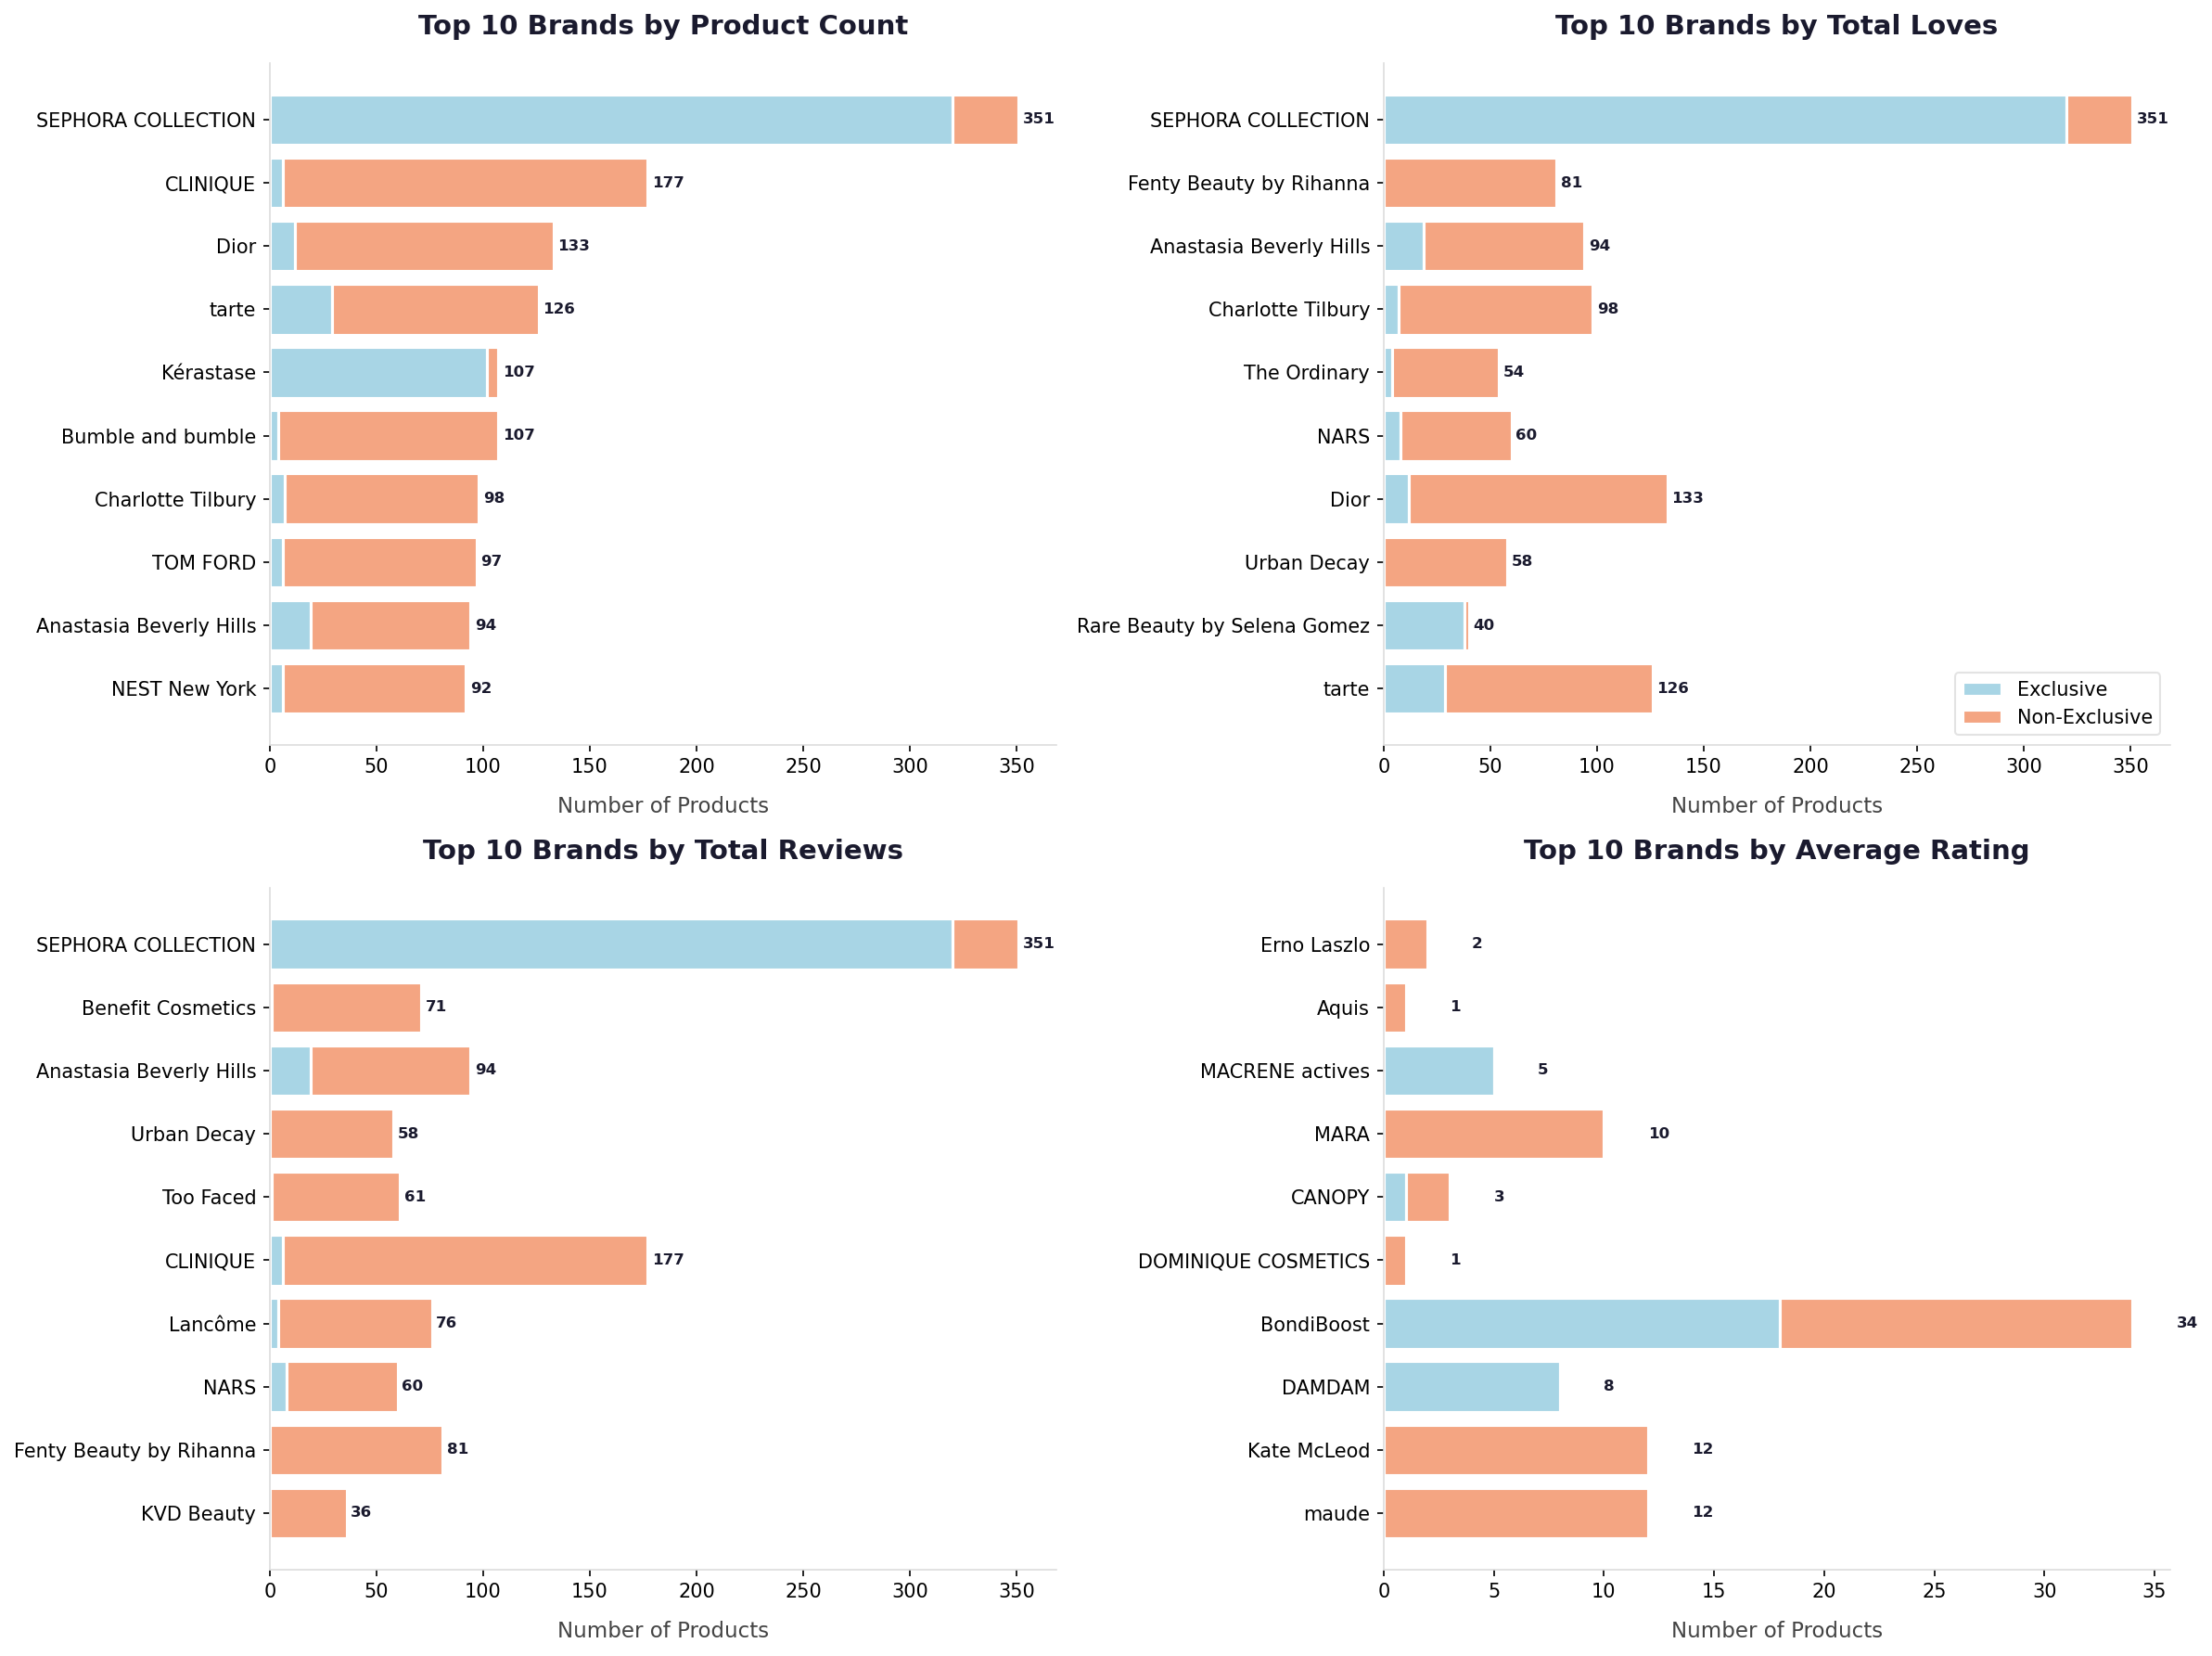

In [77]:
# TOP 10 BRANDS BY DIFFERENT METRICS

brand_stats = product_df.groupby('brand_name').agg(
    total_count=('product_id', 'count'),
    exclusive_count=('sephora_exclusive', 'sum'),
    total_loves=('loves_count', 'sum'),
    total_reviews=('reviews', 'sum'),
    avg_rating=('rating', 'mean')
).reset_index()
brand_stats['non_exclusive_count'] = brand_stats['total_count'] - brand_stats['exclusive_count']

fig, axes = plt.subplots(2, 2, figsize=(16, 12), facecolor='#ffffff', dpi=150)
for ax in axes.flatten():
    ax.set_facecolor('#ffffff')

metrics = [
    ('total_count', 'Top 10 Brands by Product Count'),
    ('total_loves', 'Top 10 Brands by Total Loves'),
    ('total_reviews', 'Top 10 Brands by Total Reviews'),
    ('avg_rating', 'Top 10 Brands by Average Rating')
]

for ax, (metric, title) in zip(axes.flatten(), metrics):
    top10 = brand_stats.nlargest(10, metric).copy()
    top10 = top10.sort_values(metric, ascending=True)
    
    y_pos = range(len(top10))
    excl_vals = top10['exclusive_count'].values
    non_excl_vals = top10['non_exclusive_count'].values
    
    ax.barh(y_pos, excl_vals, color=EXCL_COLORS[1], edgecolor='white', linewidth=1.5, label='Exclusive')
    ax.barh(y_pos, non_excl_vals, left=excl_vals, color=EXCL_COLORS[0], edgecolor='white', linewidth=1.5, label='Non-Exclusive')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top10['brand_name'])
    
    for i, (excl, non_excl) in enumerate(zip(excl_vals, non_excl_vals)):
        total = excl + non_excl
        ax.text(total + 2, i, f'{int(total):,}', ha='left', va='center', fontsize=8, fontweight='bold', color='#1a1a2e')
    
    style_axis(ax, title=title, xlabel='Number of Products', ylabel='')

axes[0, 1].legend(loc='lower right', frameon=True, facecolor='white', edgecolor='#ddd')

plt.tight_layout()
plt.show()

Sephora Collection (Sephora's private label) dominates product count and engagement while being almost 100% exclusive. Other top brands show mixed portfolios with no clear pattern between exclusivity and engagement

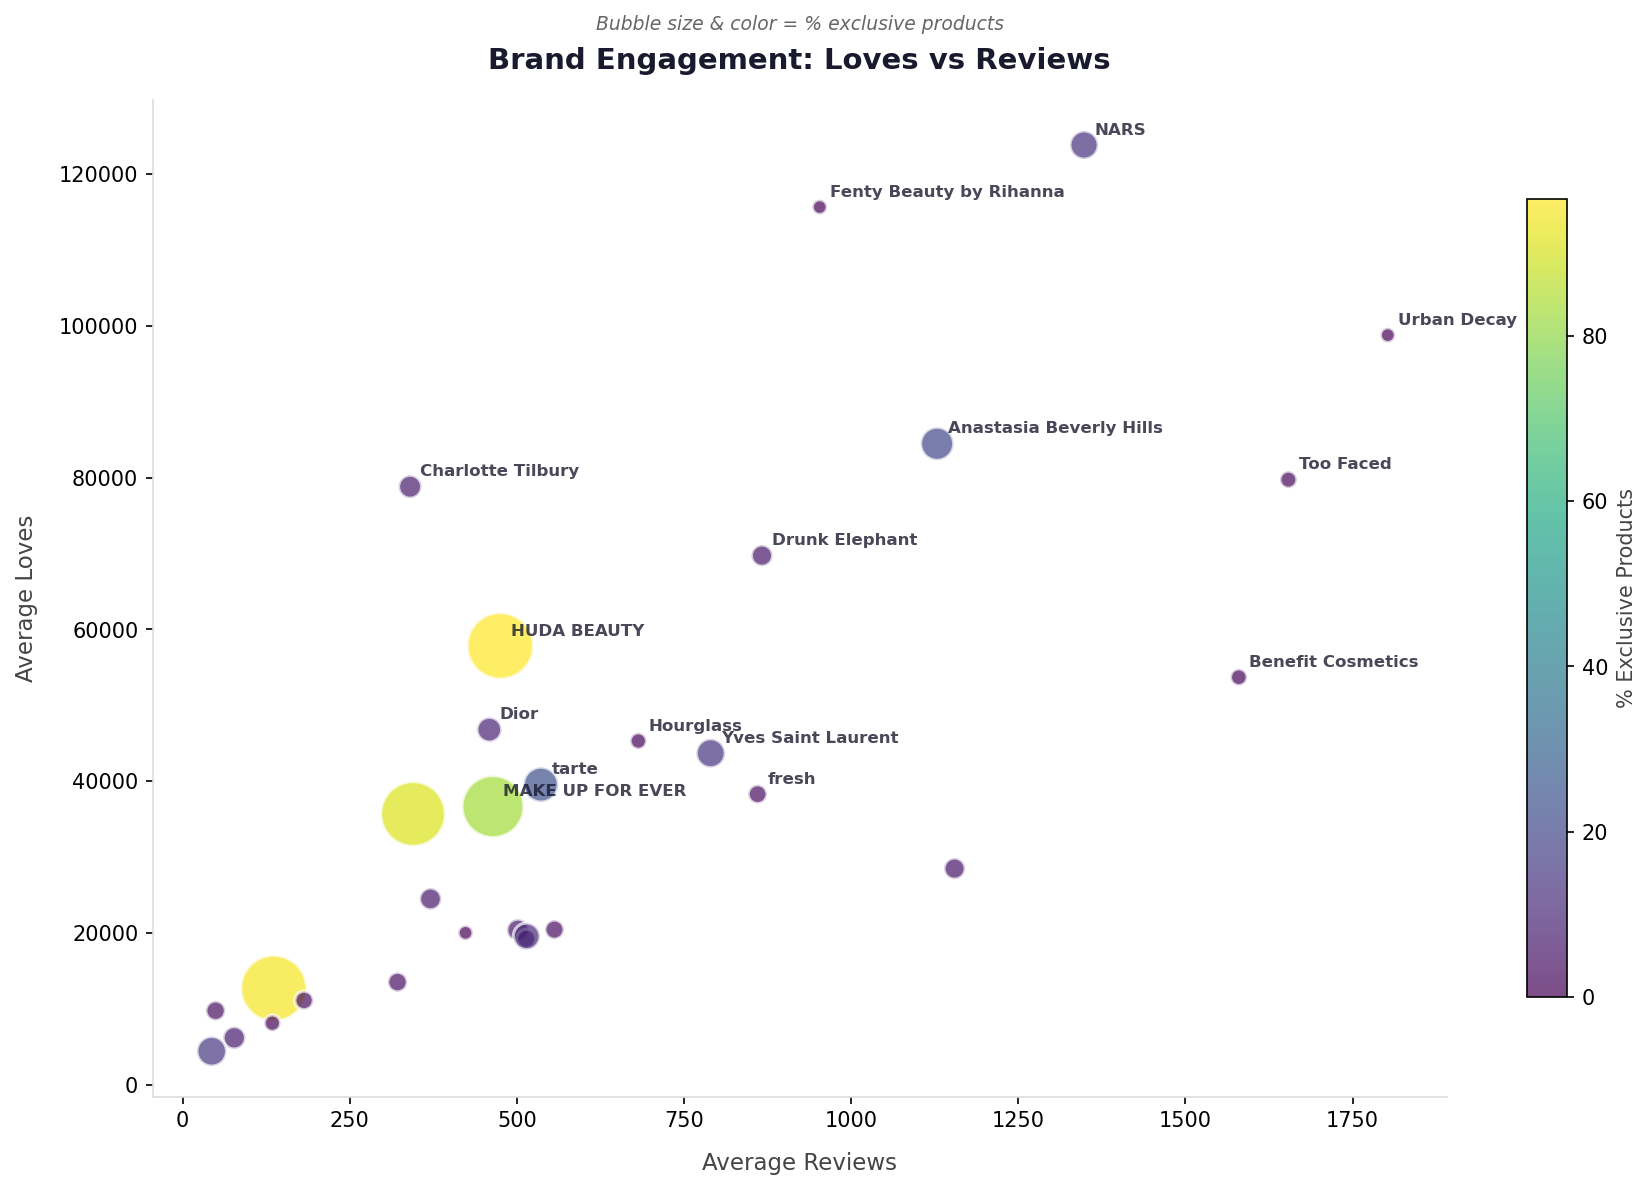

In [78]:
# BRAND ENGAGEMENT ANALYSIS

brand_stats = product_df.groupby('brand_name').agg(
    avg_loves=('loves_count', 'mean'),
    avg_reviews=('reviews', 'mean'),
    total_products=('product_id', 'count'),
    exclusive_count=('sephora_exclusive', 'sum')
).reset_index()

brand_stats['pct_exclusive'] = brand_stats['exclusive_count'] / brand_stats['total_products'] * 100

# Filter to brands with at least 5 products
brand_stats = brand_stats[brand_stats['total_products'] >= 5]
top_brands = brand_stats.nlargest(30, 'total_products')

fig, ax = plt.subplots(figsize=(12, 8), facecolor='#ffffff', dpi=150)
ax.set_facecolor('#ffffff')

scatter = ax.scatter(
    top_brands['avg_reviews'],
    top_brands['avg_loves'],
    s=top_brands['pct_exclusive'] * 10 + 50,  # Scale bubble size
    c=top_brands['pct_exclusive'],  # Color by % exclusive
    cmap='viridis',
    alpha=0.7,
    edgecolor='white',
    linewidth=1.5
)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('% Exclusive Products', fontsize=10, color='#444')

for _, row in top_brands.nlargest(15, 'avg_loves').iterrows():
    ax.annotate(
        row['brand_name'],
        (row['avg_reviews'], row['avg_loves']),
        xytext=(5, 5), textcoords='offset points',
        fontsize=8, fontweight='bold', color='#1a1a2e', alpha=0.8
    )

style_axis(ax, title='Brand Engagement: Loves vs Reviews', xlabel='Average Reviews', ylabel='Average Loves')

ax.text(0.5, 1.07, 'Bubble size & color = % exclusive products',
        transform=ax.transAxes, ha='center', fontsize=9, color='#666', style='italic')

plt.tight_layout()
plt.show()

Again here we see no clear pattern between percentage of exclusive products and engagement. High-engagement brands exist at both low and high exclusivity levels thus we won't dwell too much on brand-level analysis

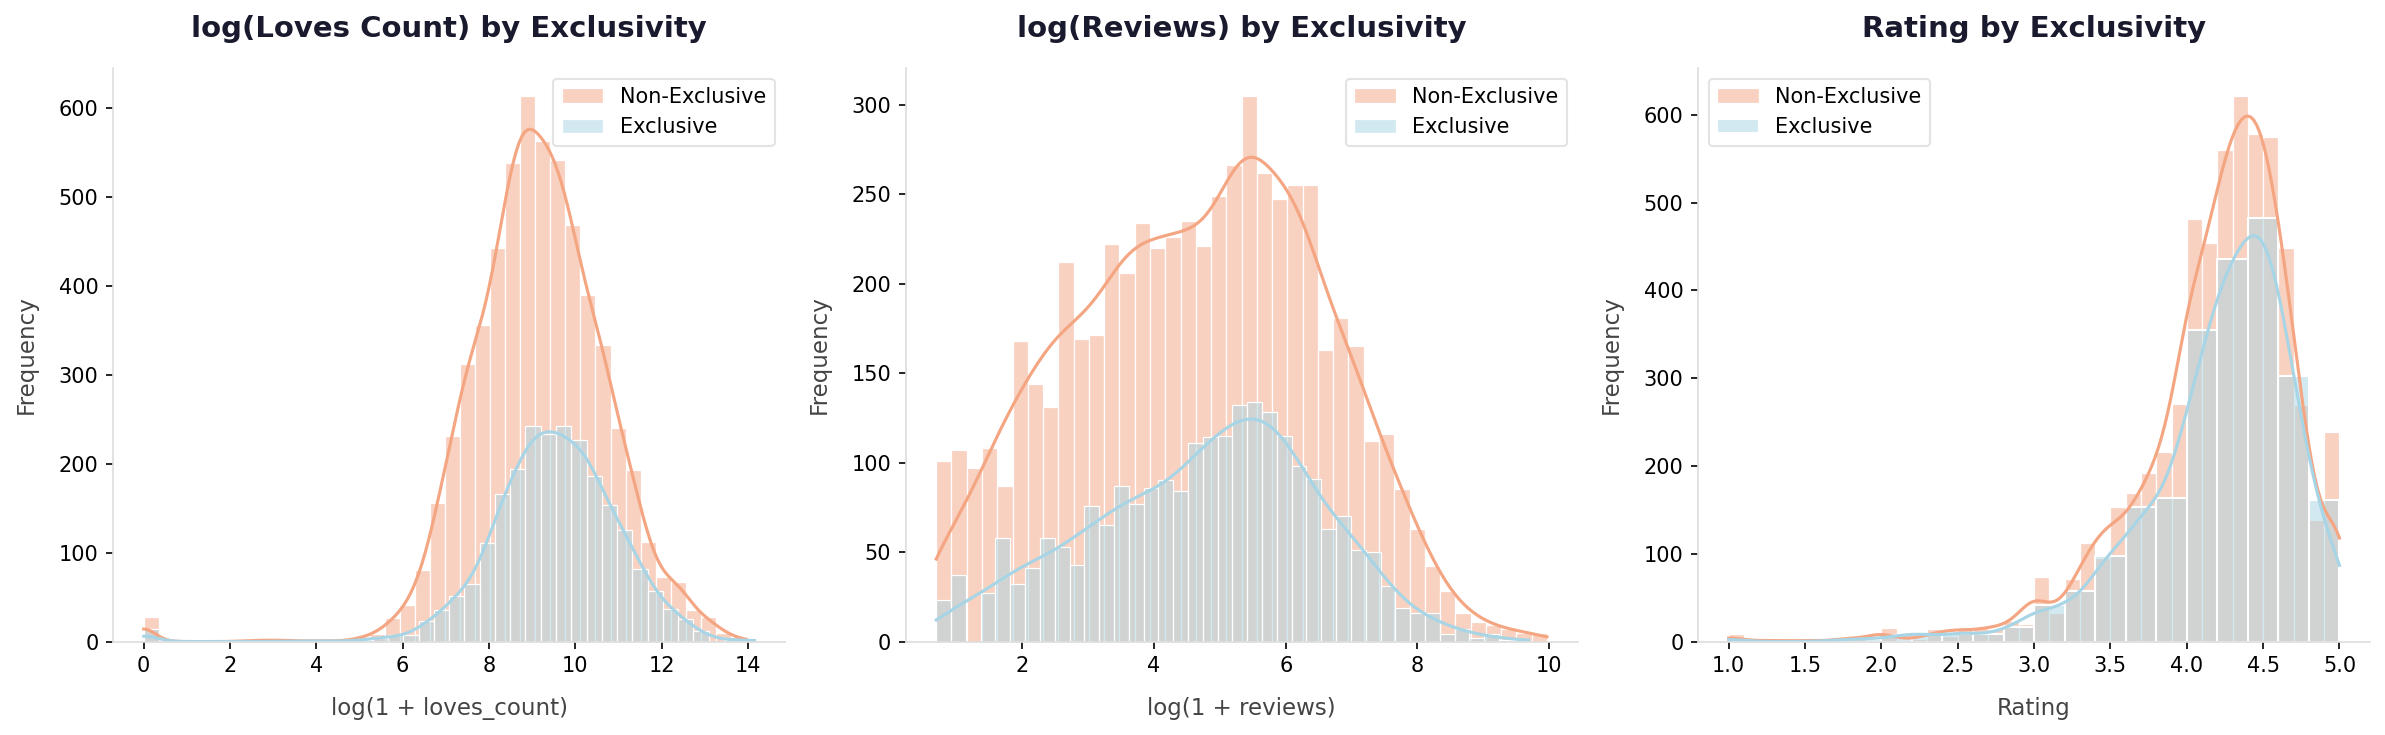

In [79]:
# ENGAGEMENT COMPARISON BY EXCLUSIVITY ===

excl_df = product_df[product_df['sephora_exclusive'] == True]
non_excl_df = product_df[product_df['sephora_exclusive'] == False]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), facecolor='#ffffff', dpi=150)
for ax in axes:
    ax.set_facecolor('#ffffff')

# Plot 1: log(loves_count)
sns.histplot(non_excl_df['log_loves'], bins=40, kde=True, alpha=0.5, label='Non-Exclusive', 
             color=EXCL_COLORS[0], edgecolor='white', ax=axes[0])
sns.histplot(excl_df['log_loves'], bins=40, kde=True, alpha=0.5, label='Exclusive', 
             color=EXCL_COLORS[1], edgecolor='white', ax=axes[0])
axes[0].legend(loc='upper right', frameon=True, facecolor='white', edgecolor='#ddd')
style_axis(axes[0], title='log(Loves Count) by Exclusivity', xlabel='log(1 + loves_count)', ylabel='Frequency')

# Plot 2: log(reviews)
sns.histplot(non_excl_df['log_reviews'], bins=40, kde=True, alpha=0.5, label='Non-Exclusive', 
             color=EXCL_COLORS[0], edgecolor='white', ax=axes[1])
sns.histplot(excl_df['log_reviews'], bins=40, kde=True, alpha=0.5, label='Exclusive', 
             color=EXCL_COLORS[1], edgecolor='white', ax=axes[1])
axes[1].legend(loc='upper right', frameon=True, facecolor='white', edgecolor='#ddd')
style_axis(axes[1], title='log(Reviews) by Exclusivity', xlabel='log(1 + reviews)', ylabel='Frequency')

# Plot 3: Rating
sns.histplot(non_excl_df['rating'], bins=40, kde=True, alpha=0.5, label='Non-Exclusive', 
             color=EXCL_COLORS[0], edgecolor='white', ax=axes[2])
sns.histplot(excl_df['rating'], bins=20, kde=True, alpha=0.5, label='Exclusive', 
             color=EXCL_COLORS[1], edgecolor='white', ax=axes[2])
axes[2].legend(loc='upper left', frameon=True, facecolor='white', edgecolor='#ddd')
style_axis(axes[2], title='Rating by Exclusivity', xlabel='Rating', ylabel='Frequency')

plt.tight_layout()
plt.show()
stats_data = [('log_loves', 'log(Loves Count)'), ('log_reviews', 'log(Reviews)'), ('rating', 'Rating')]
styled_engagement_stats(stats_data, excl_df, non_excl_df)

Exclusive products show higher mean and median values across all three engagement metrics. For loves count (log-transformed), exclusives average 9.51 versus 9.15 for non-exclusives. Reviews follow a similar pattern (4.77 vs 4.64), though with greater overlap in distributions. Ratings differ only marginally (4.21 vs 4.19), indicating the engagement gap is not primarily explained by product quality differences.

The histograms reveal that while non-exclusives contain some extremely popular outliers (longer right tails), the typical exclusive product consistently outperforms

However, are these observed differences statistically significant, or could they arise by chance? We test this below.

In [80]:
ttest_results = []

# Loves count
t_loves, p_loves_two = stats.ttest_ind(excl_df['log_loves'].dropna(), non_excl_df['log_loves'].dropna())
p_loves = p_loves_two / 2 if t_loves > 0 else 1 - p_loves_two / 2
ttest_results.append({
    'variable': 'log(Loves Count)',
    't_stat': t_loves,
    'p_value': p_loves,
    'significant': (p_loves < 0.05) and (t_loves > 0)
})

# Reviews
t_reviews, p_reviews_two = stats.ttest_ind(excl_df['log_reviews'].dropna(), non_excl_df['log_reviews'].dropna())
p_reviews = p_reviews_two / 2 if t_reviews > 0 else 1 - p_reviews_two / 2
ttest_results.append({
    'variable': 'log(Reviews)',
    't_stat': t_reviews,
    'p_value': p_reviews,
    'significant': (p_reviews < 0.05) and (t_reviews > 0)
})

# Rating
t_rating, p_rating_two = stats.ttest_ind(excl_df['rating'].dropna(), non_excl_df['rating'].dropna())
p_rating = p_rating_two / 2 if t_rating > 0 else 1 - p_rating_two / 2
ttest_results.append({
    'variable': 'Rating',
    't_stat': t_rating,
    'p_value': p_rating,
    'significant': (p_rating < 0.05) and (t_rating > 0)
})

styled_ttest_table(ttest_results, one_sided=True)

Variable,H0 (Null),H1 (Alternative),t-statistic,p-value,Significant
log(Loves Count),mu_excl = mu_non,mu_excl > mu_non,9.362,p < 0.001,Yes
log(Reviews),mu_excl = mu_non,mu_excl > mu_non,2.845,p < 0.01,Yes
Rating,mu_excl = mu_non,mu_excl > mu_non,1.719,p < 0.05,Yes


The t-tests confirm that exclusive products generate significantly higher engagement. Using a stricter threshold of α = 0.01, loves count (p < 0.001) and reviews (p < 0.01) show robust significance, while ratings (p < 0.05) meets the conventional threshold but not the stricter criterion.

Here we see exclusivity primarily drives engagement (loves, reviews) with a smaller, though still significant, impact on perceived quality (ratings). **Sephora's exclusivity strategy is associated with measurably higher customer engagement across all metrics**, with the strongest effects on customer interaction volume.

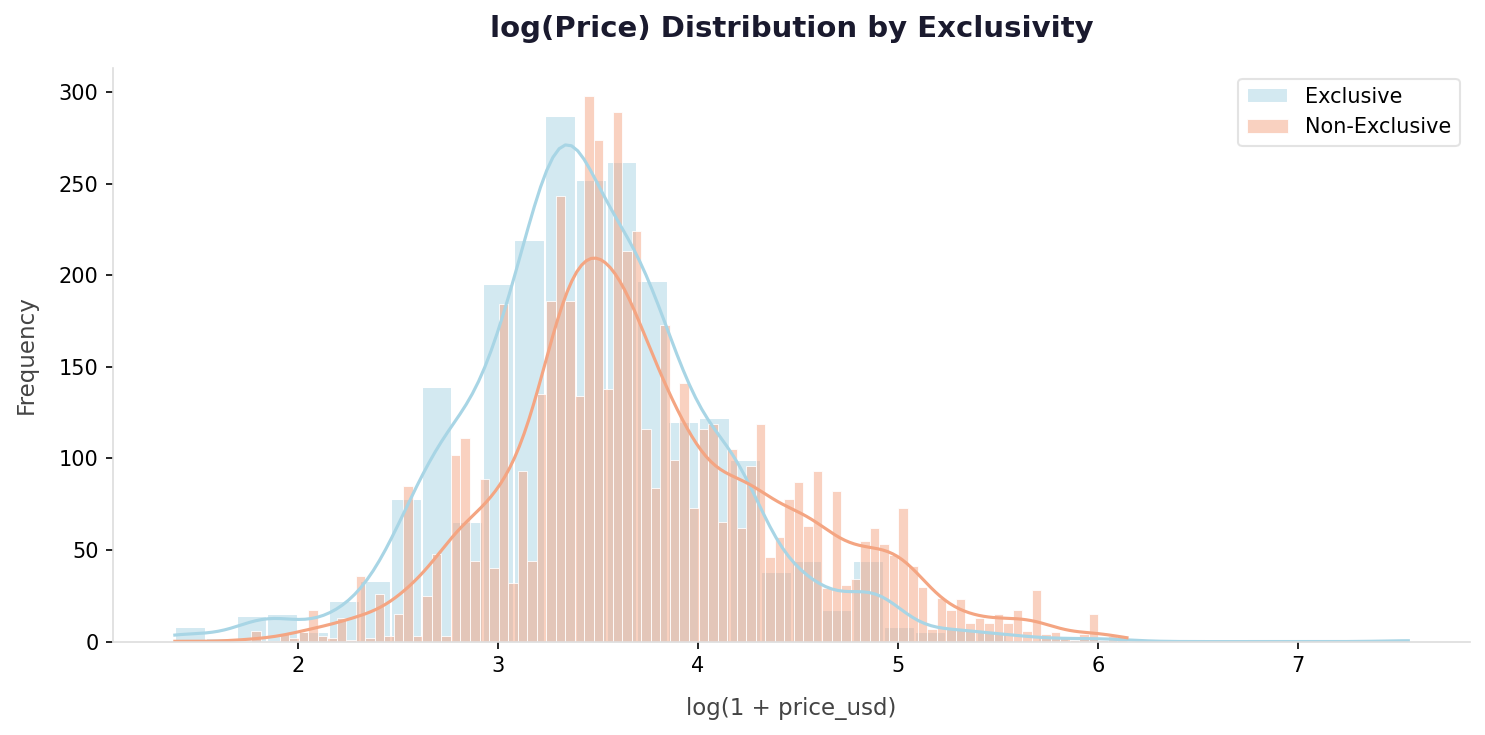

Variable,H0 (Null),H1 (Alternative),t-statistic,p-value,Significant
Price (USD),mu_excl = mu_non,mu_excl > mu_non,-13.017,p = 1.000,No


In [81]:
# PRICE COMPARISON BY EXCLUSIVITY

fig, ax = plt.subplots(figsize=(10, 5), facecolor='#ffffff', dpi=150)
ax.set_facecolor('#ffffff')

sns.histplot(excl_df['log_price'], bins=40, kde=True, alpha=0.5, label='Exclusive', 
             color=EXCL_COLORS[1], edgecolor='white', ax=ax)
sns.histplot(non_excl_df['log_price'], bins=100, kde=True, alpha=0.5, label='Non-Exclusive', 
             color=EXCL_COLORS[0], edgecolor='white', ax=ax)


ax.legend(loc='upper right', frameon=True, facecolor='white', edgecolor='#ddd')
style_axis(ax, title='log(Price) Distribution by Exclusivity', xlabel='log(1 + price_usd)', ylabel='Frequency')

plt.tight_layout()
plt.show()

styled_price_stats(excl_df['price_usd'].mean(), excl_df['price_usd'].median(), non_excl_df['price_usd'].mean(), non_excl_df['price_usd'].median())

t_price, p_price_two = stats.ttest_ind(excl_df['price_usd'].dropna(), non_excl_df['price_usd'].dropna())
p_price = p_price_two / 2 if t_price > 0 else 1 - p_price_two / 2

styled_ttest_table([{
    'variable': 'Price (USD)',
    't_stat': t_price,
    'p_value': p_price,
    'significant': (p_price < 0.05) and (t_price > 0)
}], one_sided=True)

Contrary to what one might expect, exclusive products are actually *cheaper* on average ($39.09 vs $55.98) with a lower median ($30 vs $37). The t-test confirms this difference is significant. Exclusives achieve greater engagement despite being more affordable, ruling out price as a trivial explanation for the engagement gap.

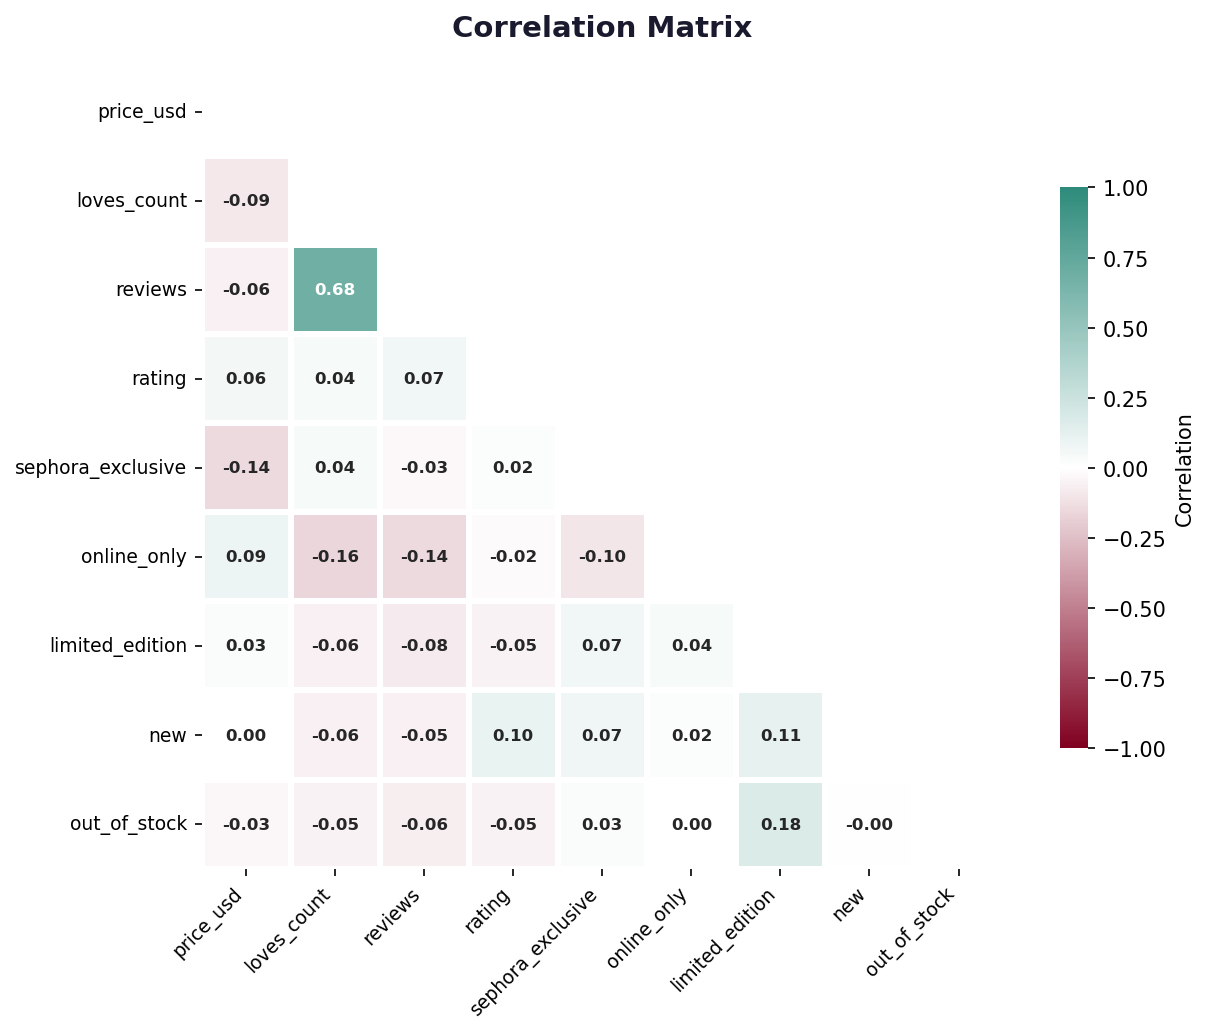

In [82]:
# CORRELATION HEATMAP

corr_cols = ['price_usd', 'loves_count', 'reviews', 'rating', 'sephora_exclusive', 'online_only', 'limited_edition', 'new', 'out_of_stock']
corr_cols = [c for c in corr_cols if c in product_df.columns]

# Calculate correlation matrix
corr = product_df[corr_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_cmap = LinearSegmentedColormap.from_list('corr_cmap', ['#800020', '#FFFFFF', '#2E8B7B'])

fig, ax = plt.subplots(figsize=(9, 7), facecolor='#ffffff', dpi=150)
ax.set_facecolor('#ffffff')

sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap=corr_cmap, center=0, vmin=-1, vmax=1, linewidths=2, linecolor='white',
            annot_kws={'fontsize': 8, 'fontweight': 'bold'}, cbar_kws={'shrink': 0.7, 'label': 'Correlation'}, ax=ax, square=True)

ax.set_title('Correlation Matrix', fontsize=14, fontweight='bold', color='#1a1a2e', pad=15)
ax.tick_params(labelsize=9)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

Loves count and reviews are strongly correlated (r = 0.68), confirming they capture related but distinct aspects of engagement. Rating has near-zero correlations with most variables, suggesting product quality perception operates independently from engagement volume and pricing.

The weak negative correlation between `sephora_exclusive` and price (r = -0.14) confirms our earlier finding that exclusives tend to be cheaper. The `online_only` flag negatively correlates with engagement metrics, while `new` and `limited_edition` show weak positive associations with each other (r = 0.11) — variables we will control for in our regression models.

##### **Key takeaway: Selecting the engagement metric**

Based on our exploratory analysis, **loves count emerges as the most suitable metric for measuring customer engagement** in subsequent predictive modelling. 4 findings support this choice:

1. The t-test for loves count yielded the highest t-statistic (9.362) and most significant p-value (p < 0.001), indicating the clearest differentiation between exclusive and non-exclusive products.

2. The correlation matrix shows loves count has minimal correlation with price (r = -0.09), meaning engagement captured by this metric is not confounded by pricing effects.

3. While correlated with reviews (r = 0.68), loves count is nearly independent of rating (r = 0.04), suggesting it captures customer interest and interaction rather than product quality assessment.

4. Unlike ratings (which require purchase and evaluation) or reviews (which require written effort), "loving" a product is a low-friction action that captures broader customer interest including aspirational engagement from customers who may not yet have purchased.

We will therefore use **loves count as the target variable** in our predictive modelling (Section 4) to understand what product attributes drive customer engagement, with exclusivity as a key predictor of interest.

#### 3.2 Reviews data

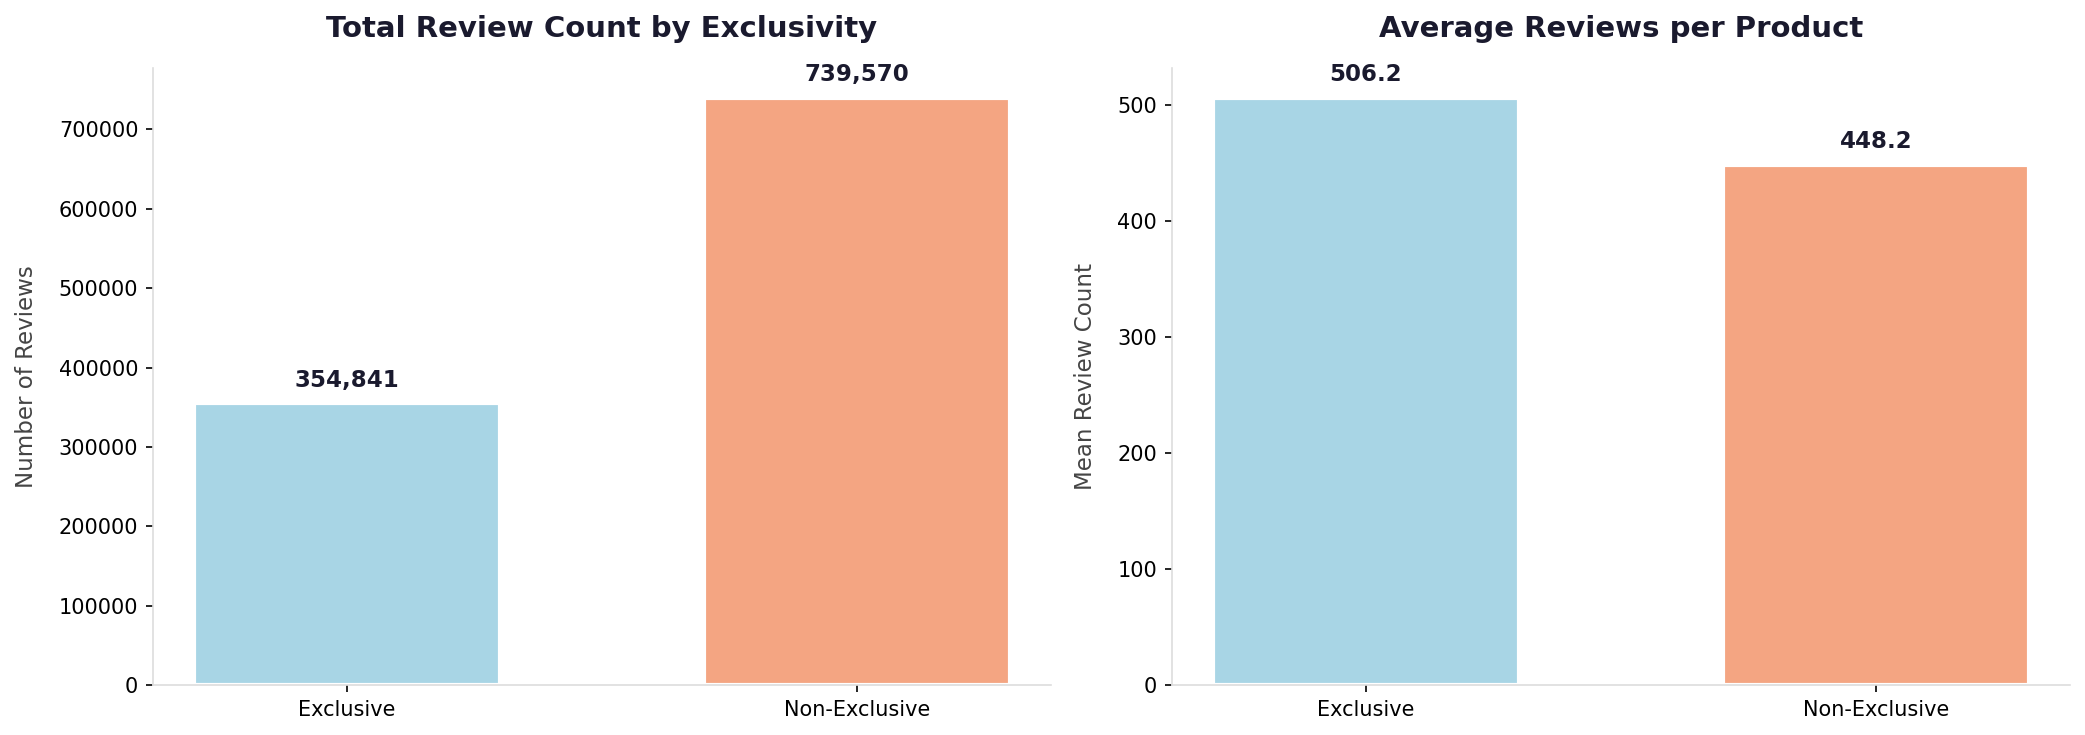

In [83]:
# REVIEW VOLUME BY EXCLUSIVITY

fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor='#ffffff', dpi=150)
for ax in axes:
    ax.set_facecolor('#ffffff')

# Left: Total review count by exclusivity
review_counts = reviews_df.groupby('sephora_exclusive').size()
labels = ['Exclusive', 'Non-Exclusive']
values = [review_counts.get(True, 0), review_counts.get(False, 0)]
bar_colors = [EXCL_COLORS[1], EXCL_COLORS[0]]

bars = axes[0].bar(labels, values, color=bar_colors, edgecolor='white', linewidth=2, width=0.6)
for bar in bars:
    h = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, h + max(values)*0.02,
                 f"{int(h):,}", ha='center', va='bottom',
                 fontsize=11, fontweight='bold', color='#1a1a2e')

style_axis(axes[0], title='Total Review Count by Exclusivity', xlabel='', ylabel='Number of Reviews')

# Right: Average reviews per product
avg_reviews = reviews_df.groupby('sephora_exclusive').apply(
    lambda x: x.groupby('product_id').size().mean()
)
avg_values = [avg_reviews.get(True, 0), avg_reviews.get(False, 0)]

bars = axes[1].bar(labels, avg_values, color=bar_colors, edgecolor='white', linewidth=2, width=0.6)
for bar in bars:
    h = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, h + max(avg_values)*0.02,
                 f"{h:.1f}", ha='center', va='bottom',
                 fontsize=11, fontweight='bold', color='#1a1a2e')

style_axis(axes[1], title='Average Reviews per Product', xlabel='', ylabel='Mean Review Count')

plt.tight_layout()
plt.show()

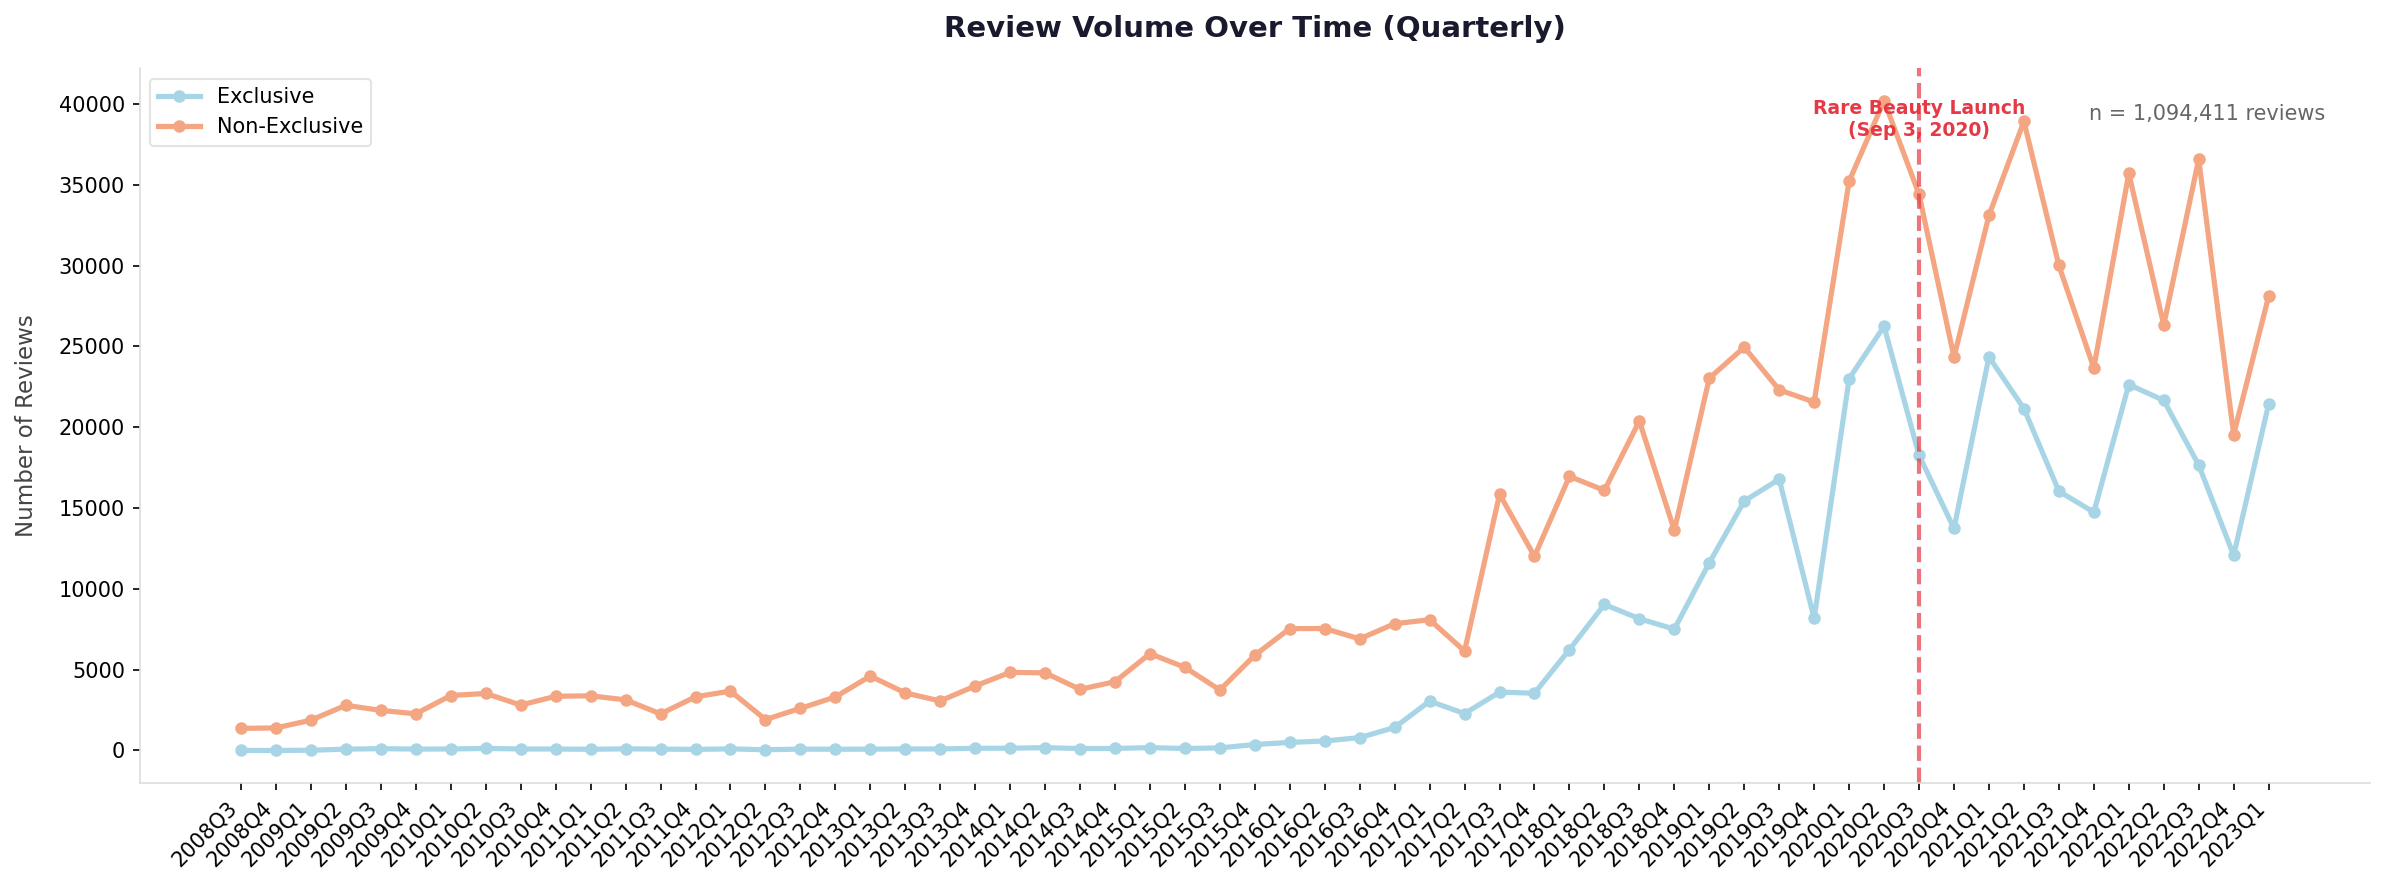

In [84]:
# REVIEW VOLUME OVER TIME
reviews_df['submission_date'] = pd.to_datetime(reviews_df['submission_time'], errors='coerce')
reviews_df['year_quarter'] = reviews_df['submission_date'].dt.to_period('Q')

quarterly_reviews = reviews_df.groupby(['year_quarter', 'sephora_exclusive']).size().unstack(fill_value=0).sort_index()

fig, ax = plt.subplots(figsize=(16, 6), facecolor='#ffffff', dpi=150)
ax.set_facecolor('#ffffff')

x = range(len(quarterly_reviews))
ax.plot(x, quarterly_reviews[True].values, color=EXCL_COLORS[1], linewidth=2.5, label='Exclusive', marker='o', markersize=5)
ax.plot(x, quarterly_reviews[False].values, color=EXCL_COLORS[0], linewidth=2.5, label='Non-Exclusive', marker='o', markersize=5)

# Mark Q3 2020 (Rare Beauty launch)
q3_2020_idx = list(quarterly_reviews.index.astype(str)).index('2020Q3') if '2020Q3' in quarterly_reviews.index.astype(str).tolist() else None
if q3_2020_idx:
    ax.axvline(x=q3_2020_idx, color='#E63946', linestyle='--', linewidth=2, alpha=0.7)
    ax.annotate('Rare Beauty Launch\n(Sep 3, 2020)', xy=(q3_2020_idx, ax.get_ylim()[1]*0.9),
                ha='center', fontsize=9, color='#E63946', fontweight='bold')

ax.set_xticks(range(len(quarterly_reviews)))
ax.set_xticklabels([str(q) for q in quarterly_reviews.index], rotation=45, ha='right', fontsize=8)
ax.legend(loc='upper left', frameon=True, facecolor='white', edgecolor='#ddd')
ax.annotate(f'n = {len(reviews_df):,} reviews', xy=(0.98, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=10, color='#666')

style_axis(ax, title='Review Volume Over Time (Quarterly)', xlabel='', ylabel='Number of Reviews')
plt.tight_layout()
plt.show()

##### Observations and takeaways
- While non-exclusive products generate more total reviews (739,570 vs 354,841), this reflects their larger catalog share. When normalised per product, exclusive products average 506 reviews compared to 448 for non-exclusives (13% higher review rate).
- The time series reveals that exclusive product reviews only began appearing around 2017, suggesting Sephora's exclusivity strategy is relatively recent. Both categories show substantial growth post-2017, with exclusives maintaining a consistent proportion of total review activity.
- We do not dwell further on review-level metrics here, as raw counts and averages provide limited insight into the *quality* of customer engagement. To understand whether exclusives generate more positive, enthusiastic, or detailed feedback, we turn to sentiment analysis in the section 5.

## **4. MODELLING**

#### 4.1 OLS Regression: Does exclusivity drive engagement?

EDA showed that exclusive products have higher engagement metrics. But are these differences statistically significant after controlling for other factors? Here, we use `loves count` as our primary engagement metric (based on our EDA findings) and estimate three models, progressively adding controls:

**Model specification:**
$$
\log(\text{loves}) = \beta_0 + \beta_1 \cdot \text{exclusive} + \beta_2 \cdot \log(\text{price}) 
+ \beta_3 \cdot \text{rating} + \beta_4 \cdot \log(\text{reviews}) + \beta_5 \cdot \text{online\_only} + \beta_6 \cdot \text{limited\_edition} + \beta_7 \cdot \text{new} + \gamma \cdot \text{Category} + \varepsilon
$$

| Variable | Role | Rationale | Models |
|----------|------|-----------|--------|
| `log(loves_count)` | Dependent | Log-transformed to address skewness | 1, 2, 3 |
| `sephora_exclusive` | Key predictor | Binary indicator—our variable of interest | 1, 2, 3 |
| `log(price_usd)` | Control | Captures price effects | 1, 2, 3 |
| `primary_category` | Fixed effects | Category-level differences | 1, 2, 3 |
| `rating` | Control | Product quality perception | 2, 3 |
| `log(reviews)` | Control | Product visibility proxy | 3 |
| `online_only` | Control | Availability channel effect | 3 |
| `limited_edition` | Control | Scarcity signal | 3 |
| `new` | Control | Product recency | 3 |

In [85]:
# Prepare regression dataset
df_reg = product_df.copy()

reg_vars = ['log_loves', 'log_price', 'rating', 'log_reviews', 'sephora_exclusive', 'online_only', 'limited_edition', 'new', 'primary_category']
df_reg = df_reg.dropna(subset=[v for v in reg_vars if v in df_reg.columns])

print(f"Regression sample size: {len(df_reg):,} products")
print(f"Exclusive products: {df_reg['sephora_exclusive'].sum():,} ({df_reg['sephora_exclusive'].mean()*100:.1f}%)")

# Model 1: Basic - exclusivity + price + category
model1 = smf.ols('log_loves ~ sephora_exclusive + log_price + C(primary_category)', data=df_reg).fit()

# Model 2: Add rating
model2 = smf.ols('log_loves ~ sephora_exclusive + log_price + rating + C(primary_category)', data=df_reg).fit()

# Model 3: Full model with all controls
model3 = smf.ols('log_loves ~ sephora_exclusive + log_price + rating + log_reviews + online_only + limited_edition + new + C(primary_category)', 
                 data=df_reg).fit()

print("=" * 80)
print("OLS REGRESSION RESULTS: Does exclusivity drive engagement?")
print("=" * 80)

results_list = []
for name, model in [('Basic', model1), ('+ Rating', model2), ('Full Model', model3)]:
    excl_key = 'sephora_exclusive[T.True]' if 'sephora_exclusive[T.True]' in model.params else 'sephora_exclusive'
    
    results_list.append({
        'Model': name,
        'Excl. Coef': model.params.get(excl_key, np.nan),
        'Std. Error': model.bse.get(excl_key, np.nan),
        'p-value': model.pvalues.get(excl_key, np.nan),
        'R²': model.rsquared,
        'Adj. R²': model.rsquared_adj,
        'N': int(model.nobs)
    })

results_table = pd.DataFrame(results_list)
styled_table(results_table, caption='Exclusivity coefficient across model specifications', mode='preview')

Regression sample size: 8,216 products
Exclusive products: 2,310 (28.1%)
OLS REGRESSION RESULTS: Does exclusivity drive engagement?


,Model,Excl. Coef,Std. Error,p-value,R²,Adj. R²,N
0,Basic,0.158,0.037,0.000,0.132,0.131,"8,216"
1,+ Rating,0.149,0.037,0.000,0.136,0.135,"8,216"
2,Full Model,0.153,0.027,0.000,0.531,0.530,"8,216"


The exclusivity coefficient remains stable across all three specifications (0.153–0.158).

In [86]:
print("\n" + "=" * 80)
print("FULL MODEL WITH ALL CONTROLS SUMMARY")
print("=" * 80)
print(model3.summary())

excl_key = 'sephora_exclusive[T.True]' if 'sephora_exclusive[T.True]' in model3.params else 'sephora_exclusive'
excl_coef = model3.params[excl_key]
excl_pval = model3.pvalues[excl_key]
excl_se = model3.bse[excl_key]

pct_effect = (np.exp(excl_coef) - 1) * 100

ci_lower = excl_coef - 1.96 * excl_se
ci_upper = excl_coef + 1.96 * excl_se
pct_ci_lower = (np.exp(ci_lower) - 1) * 100
pct_ci_upper = (np.exp(ci_upper) - 1) * 100

styled_ols_result(pct_effect, excl_pval, pct_ci_lower, pct_ci_upper)


FULL MODEL WITH ALL CONTROLS SUMMARY
                            OLS Regression Results                            
Dep. Variable:              log_loves   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     617.9
Date:                Fri, 30 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:34:55   Log-Likelihood:                -12242.
No. Observations:                8216   AIC:                         2.452e+04
Df Residuals:                    8200   BIC:                         2.463e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

Summary of OLS results:

- The full model explains 53% of variance in log(loves). Exclusivity independently predicts higher engagement, with exclusive products receiving 16.5% more loves than comparable non-exclusives (p < 0.001, 95% CI: 10.4%–22.9%).

- The exclusivity premium remains virtually unchanged across specifications (17.1% → 16.5%), confirming it is not an artifact of price, rating, or review volume differences.

- The strongest predictor is `log_reviews` (0.53): products with more reviews naturally accumulate more loves, confirming the strong correlation (r = 0.68) we observed in EDA

- `limited_edition` shows a larger effect than exclusivity (+81% vs +16.5%), suggesting scarcity signals are important drivers of engagement. We examine whether limited_edition also predicts exclusivity in the next section.

- Both `rating` (-0.16) and `new` (-0.69) show negative associations. For new products, this reflects insufficient time to accumulate engagement. For rating, highly-reviewed products often have moderate rather than extreme ratings. The online_only flag (-0.28) indicates in-store availability matters for engagement.

#### 4.2 Logistic Regression: What predicts exclusivity?

What kind of product characteristics make a product more likely to be exclusive? To answer this, we flip the model making exclusivity the dependent variable.

**Model specification:**

$$P(\text{exclusive} = 1) = \text{logit}^{-1}(\beta_0 + \beta_1 \cdot \text{log\_price} + \beta_2 \cdot \text{rating} + \beta_3 \cdot \text{online\_only} + \beta_4 \cdot \text{limited\_edition} + \beta_5 \cdot \text{new} + \gamma \cdot \text{category})$$

In [87]:
df_reg['sephora_exclusive_int'] = df_reg['sephora_exclusive'].astype(int)
logit_model = smf.logit(
    'sephora_exclusive_int ~ log_price + rating + online_only + limited_edition + new + C(primary_category)',
    data=df_reg
).fit(disp=0)

print("=" * 80)
print("LOGISTIC REGRESSION: What predicts exclusivity?")
print("=" * 80)

print(logit_model.summary())
# Non-category coefficients
main_vars = ['log_price', 'rating', 'online_only[T.True]', 'limited_edition[T.True]', 'new[T.True]']
or_data = []
for var in main_vars:
    if var in logit_model.params.index:
        coef = logit_model.params[var]
        pval = logit_model.pvalues[var]
        odds_ratio = np.exp(coef)
        ci_low = np.exp(coef - 1.96 * logit_model.bse[var])
        ci_high = np.exp(coef + 1.96 * logit_model.bse[var])
        
        or_data.append({
            'Variable': var.replace('[T.True]', ''),
            'Odds Ratio': round(odds_ratio, 3),
            'CI Lower': round(ci_low, 3),
            'CI Upper': round(ci_high, 3),
            'p-value': round(pval, 4),
            'Significant': '✓' if pval < 0.05 else ''
        })

or_table = pd.DataFrame(or_data)
styled_table(or_table, caption='Odds Ratios for Exclusivity Predictors', mode='preview')

LOGISTIC REGRESSION: What predicts exclusivity?
                             Logit Regression Results                            
Dep. Variable:     sephora_exclusive_int   No. Observations:                 8216
Model:                             Logit   Df Residuals:                     8202
Method:                              MLE   Df Model:                           13
Date:                   Fri, 30 Jan 2026   Pseudo R-squ.:                 0.06260
Time:                           11:34:55   Log-Likelihood:                -4575.1
converged:                         False   LL-Null:                       -4880.7
Covariance Type:               nonrobust   LLR p-value:                3.287e-122
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.5561      0.276      2.014      0.044

,Variable,Odds Ratio,CI Lower,CI Upper,p-value,Significant
0,log_price,0.517,0.474,0.563,0.000,✓
1,rating,1.223,1.105,1.354,0.000,✓
2,online_only,0.608,0.530,0.698,0.000,✓
3,limited_edition,2.055,1.684,2.507,0.000,✓
4,new,1.738,1.426,2.118,0.000,✓


- Exclusive products tend to be **cheaper** (OR = 0.52 for log_price) aligning with our EDA finding
- Exclusivity is also bundled with **limited_edition** (OR = 2.05) and **new** (OR = 1.74) flags, suggesting Sephora uses an integrated launch strategy combining scarcity and rarity

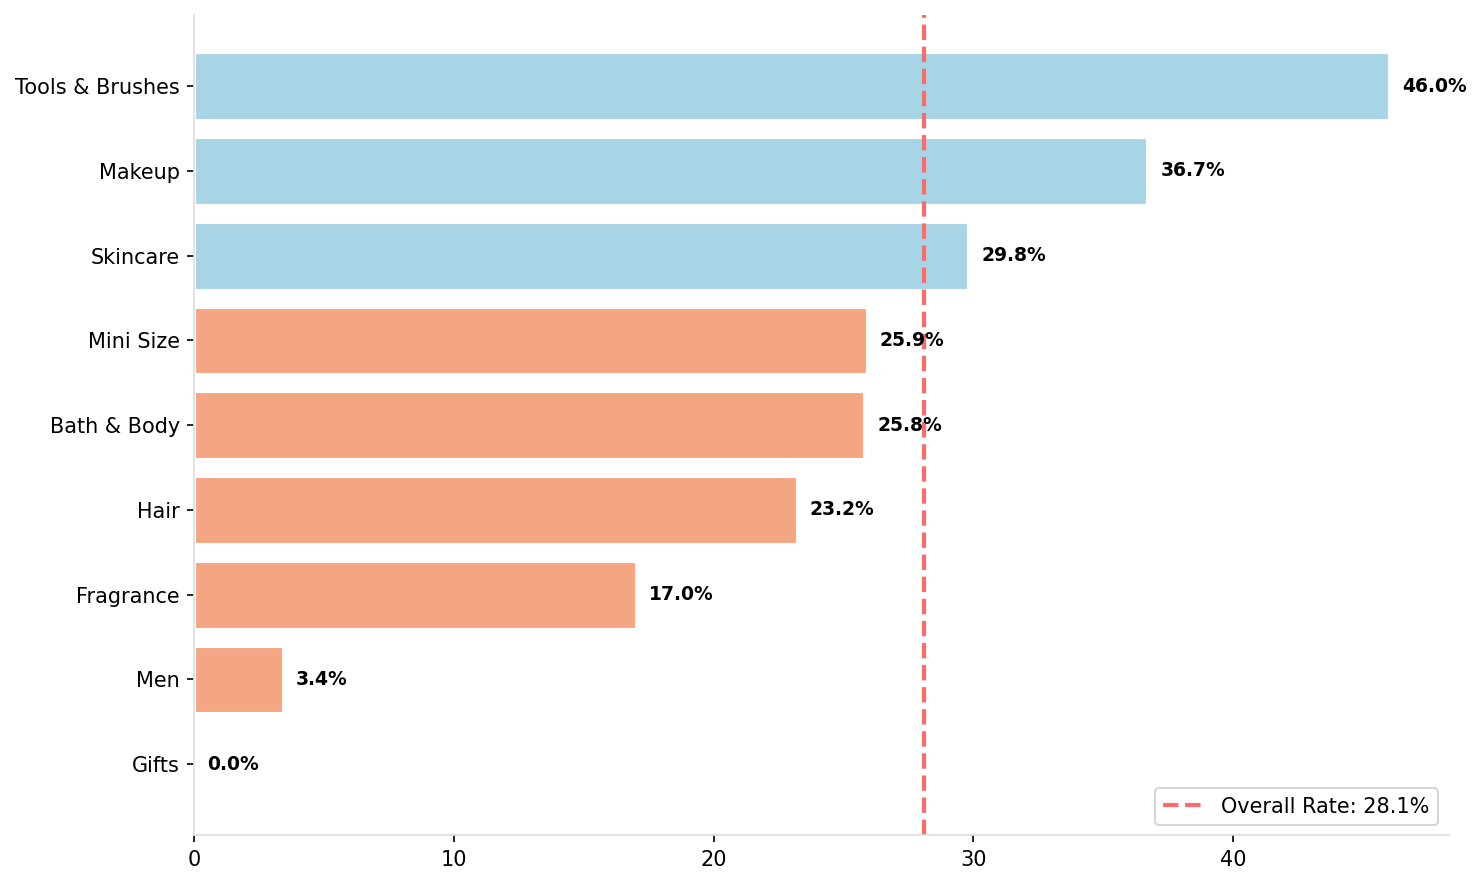

,N Exclusive,N Total,Excl. Rate %,Avg log(Loves)
primary_category,,,,
Tools & Brushes,23,50,46.000,9.201
Makeup,854,"2,328",36.700,10.000
Skincare,701,"2,351",29.800,9.231
Mini Size,71,274,25.900,9.363
Bath & Body,102,395,25.800,8.858
Hair,329,"1,416",23.200,8.755
Fragrance,228,"1,339",17.000,8.666
Men,2,59,3.400,8.267
Gifts,0,4,0.000,0.000


In [88]:
# Exclusivity rate by category
category_analysis = df_reg.groupby('primary_category').agg({
    'sephora_exclusive': ['sum', 'count', 'mean'],
    'log_loves': 'mean',
    'log_price': 'mean'
}).round(3)
category_analysis.columns = ['N Exclusive', 'N Total', 'Excl. Rate', 'Avg log(Loves)', 'Avg log(Price)']
category_analysis['Excl. Rate %'] = (category_analysis['Excl. Rate'] * 100).round(1)
category_analysis = category_analysis.sort_values('Excl. Rate %', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6), facecolor='#ffffff', dpi=150)
ax.set_facecolor('#ffffff')

overall_rate = df_reg['sephora_exclusive'].mean() * 100
colors = [EXCL_COLORS[1] if pct > overall_rate else EXCL_COLORS[0] 
          for pct in category_analysis['Excl. Rate %']]

bars = ax.barh(range(len(category_analysis)), category_analysis['Excl. Rate %'], 
               color=colors, edgecolor='white', linewidth=1.5)

ax.axvline(x=overall_rate, color='#FF6B6B', linestyle='--', linewidth=2, 
           label=f'Overall Rate: {overall_rate:.1f}%')
ax.set_yticks(range(len(category_analysis)))
ax.set_yticklabels(category_analysis.index, fontsize=10)
ax.set_xlabel('Exclusivity Rate (%)', fontsize=11)
ax.set_title('Exclusivity Rate by Product Category', fontweight='bold', fontsize=14, pad=15)
ax.legend(loc='lower right')
ax.invert_yaxis()

for bar, pct in zip(bars, category_analysis['Excl. Rate %']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', va='center', fontsize=9, fontweight='bold')

style_axis(ax, '', '', '')
plt.tight_layout()
plt.show()

styled_table(category_analysis[['N Exclusive', 'N Total', 'Excl. Rate %', 'Avg log(Loves)']], 
             caption='Exclusivity Analysis by Category', mode='preview')

Summary of Logistic Regression results:

- Exclusive products tend to be cheaper (OR = 0.52 for log_price), aligning with our EDA finding that exclusives are more affordable than non-exclusives.

- The limited_edition flag strongly predicts exclusivity (OR = 2.05): limited edition products are twice as likely to be exclusive. Similarly, new products are 1.7x more likely to be exclusive (OR = 1.74). This suggests Sephora bundles exclusivity with scarcity and novelty signals as part of an integrated launch strategy.

- Online-only products are less likely to be exclusive (OR = 0.61), indicating Sephora reserves exclusivity for products with in-store presence.

- Higher-rated products are slightly more likely to be exclusive (OR = 1.22), though this effect is modest.

- Category matters: Makeup products are more likely to be exclusive, while Men and Mini Size categories are less likely.

These patterns suggest Sephora's exclusivity assignment is deliberate rather than random

## **5. SENTIMENT ANALYSIS**

Our modelling shows exclusive products receive more engagement but does this reflect genuine customer enthusiasm or simply higher visibility? We analyse review text to investigate:

1. Do exclusive products receive longer, more detailed reviews?
2. Are reviews for exclusive products more positive?
3. Do customers use different emotional language for exclusives?

#### 5.1 Do exclusive products receive longer, more detailed reviews?

In [89]:
# Data preparation
product_excl_map = product_df[['product_id', 'sephora_exclusive', 'loves_count', 'primary_category']].copy()
product_excl_map['product_id'] = product_excl_map['product_id'].astype(str)
reviews_df['product_id'] = reviews_df['product_id'].astype(str)

if 'sephora_exclusive' in reviews_df.columns:
    reviews_df = reviews_df.drop(columns=['sephora_exclusive'])

reviews_analysis = reviews_df.merge(product_excl_map, on='product_id', how='inner')

print(f"Total reviews: {len(reviews_analysis):,}")
print(f"Exclusive products: {reviews_analysis['sephora_exclusive'].sum():,} ({reviews_analysis['sephora_exclusive'].mean()*100:.1f}%)")

Total reviews: 1,094,411
Exclusive products: 354,841 (32.4%)



T-test for mean difference: t = -16.227, p = 3.30e-59


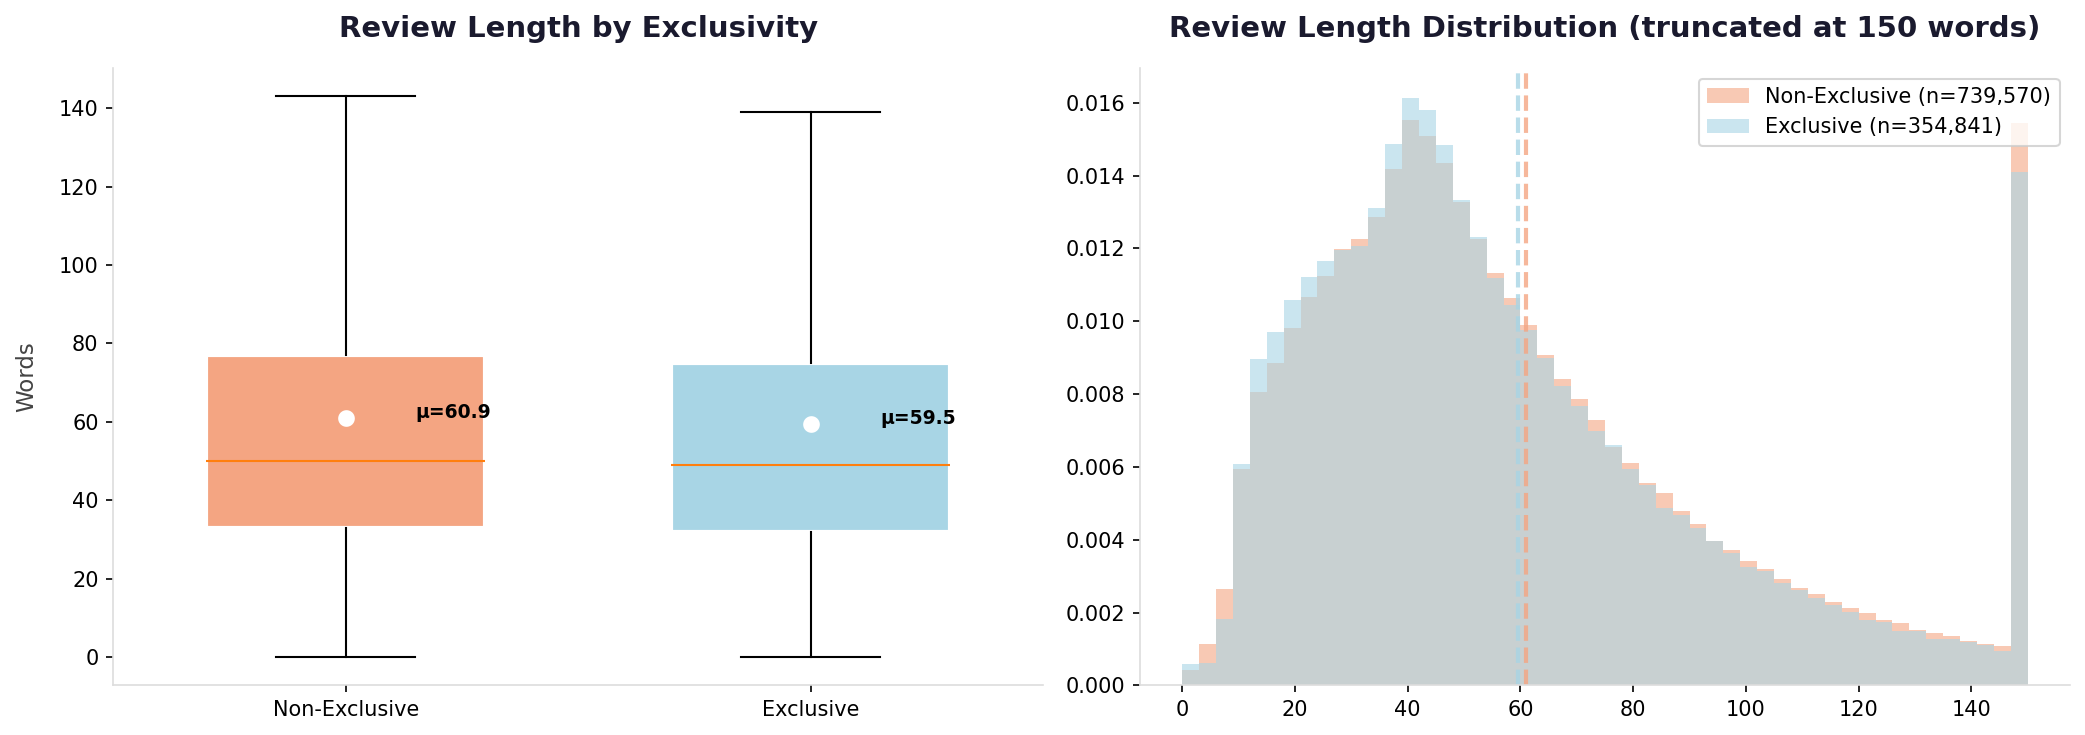

In [90]:
# Calculate review length (word count)
reviews_analysis['review_length'] = reviews_analysis['review_text'].fillna('').apply(
    lambda x: len(str(x).split())
)

# Statistics by exclusivity
excl_reviews = reviews_analysis[reviews_analysis['sephora_exclusive'] == True]
non_excl_reviews = reviews_analysis[reviews_analysis['sephora_exclusive'] == False]

length_stats = pd.DataFrame({
    'Metric': ['N Reviews', 'Mean Length', 'Median Length', 'Std Dev', '25th Percentile', '75th Percentile'],
    'Exclusive': [
        len(excl_reviews),
        excl_reviews['review_length'].mean(),
        excl_reviews['review_length'].median(),
        excl_reviews['review_length'].std(),
        excl_reviews['review_length'].quantile(0.25),
        excl_reviews['review_length'].quantile(0.75)
    ],
    'Non-Exclusive': [
        len(non_excl_reviews),
        non_excl_reviews['review_length'].mean(),
        non_excl_reviews['review_length'].median(),
        non_excl_reviews['review_length'].std(),
        non_excl_reviews['review_length'].quantile(0.25),
        non_excl_reviews['review_length'].quantile(0.75)
    ]
})
length_stats = length_stats.round(2)

styled_table(length_stats, caption='Review Length Statistics by Exclusivity')

# T-test
t_stat, p_val = stats.ttest_ind(
    excl_reviews['review_length'], 
    non_excl_reviews['review_length']
)
print(f"\nT-test for mean difference: t = {t_stat:.3f}, p = {p_val:.2e}")

fig, axes = create_figure(1, 2, figsize=(14, 5))
bp = axes[0].boxplot(
    [non_excl_reviews['review_length'], excl_reviews['review_length']], 
    labels=['Non-Exclusive', 'Exclusive'],
    patch_artist=True,
    showfliers=False,
    widths=0.6
)
bp['boxes'][0].set_facecolor(EXCL_COLORS[0])
bp['boxes'][1].set_facecolor(EXCL_COLORS[1])
for box in bp['boxes']:
    box.set_edgecolor('white')
    box.set_linewidth(2)

axes[0].set_ylabel('Review Length (words)', fontsize=11)
style_axis(axes[0], 'Review Length by Exclusivity', '', 'Words')

# Add means
for i, (data, color) in enumerate([(non_excl_reviews['review_length'], EXCL_COLORS[0]), 
                                    (excl_reviews['review_length'], EXCL_COLORS[1])]):
    axes[0].scatter(i+1, data.mean(), color='white', s=100, zorder=5, edgecolor=color, linewidth=2)
    axes[0].annotate(f'μ={data.mean():.1f}', (i+1.15, data.mean()), fontsize=9, fontweight='bold')

# Histogram
axes[1].hist(non_excl_reviews['review_length'].clip(upper=150), bins=50, alpha=0.6, 
             label=f'Non-Exclusive (n={len(non_excl_reviews):,})', color=EXCL_COLORS[0], density=True)
axes[1].hist(excl_reviews['review_length'].clip(upper=150), bins=50, alpha=0.6, 
             label=f'Exclusive (n={len(excl_reviews):,})', color=EXCL_COLORS[1], density=True)
axes[1].axvline(x=non_excl_reviews['review_length'].mean(), color=EXCL_COLORS[0], 
                linestyle='--', linewidth=2, alpha=0.8)
axes[1].axvline(x=excl_reviews['review_length'].mean(), color=EXCL_COLORS[1], 
                linestyle='--', linewidth=2, alpha=0.8)
axes[1].set_xlabel('Review Length (words)', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].legend(loc='upper right')
style_axis(axes[1], 'Review Length Distribution (truncated at 150 words)', '', '')

plt.tight_layout()
plt.show()

Non-exclusive products have slightly longer reviews (mean: 60.9 words) than exclusive products (mean: 59.5 words). While the t-test is statistically significant (p < 0.001), the difference of ~1.4 words is negligible in practical terms. Customers write similarly detailed reviews regardless of exclusivity.

#### 5.2 Are reviews for exclusive products more positive?

In [91]:
# Sample of 100k reviews
np.random.seed(42)
sample_size = min(100000, len(reviews_analysis))
reviews_sample = reviews_analysis.sample(n=sample_size).copy()

print(f"Analyzing sentiment for {sample_size:,} sampled reviews...")

reviews_sample['polarity'] = reviews_sample['review_text'].apply(get_sentiment)

excl_polarity = reviews_sample[reviews_sample['sephora_exclusive'] == True]['polarity'].dropna()
non_excl_polarity = reviews_sample[reviews_sample['sephora_exclusive'] == False]['polarity'].dropna()

sentiment_stats = pd.DataFrame({
    'Metric': ['N Reviews', 'Mean Polarity', 'Median Polarity', 'Std Dev', '% Positive (>0)', '% Negative (<0)'],
    'Exclusive': [
        len(excl_polarity),
        excl_polarity.mean(),
        excl_polarity.median(),
        excl_polarity.std(),
        (excl_polarity > 0).mean() * 100,
        (excl_polarity < 0).mean() * 100
    ],
    'Non-Exclusive': [
        len(non_excl_polarity),
        non_excl_polarity.mean(),
        non_excl_polarity.median(),
        non_excl_polarity.std(),
        (non_excl_polarity > 0).mean() * 100,
        (non_excl_polarity < 0).mean() * 100
    ]
}).round(4)

styled_table(sentiment_stats, caption='Sentiment Statistics by Exclusivity', mode='preview')

Analyzing sentiment for 100,000 sampled reviews...


,Metric,Exclusive,Non-Exclusive
0,N Reviews,"32,447.000","67,439.000"
1,Mean Polarity,0.242,0.237
2,Median Polarity,0.240,0.232
3,Std Dev,0.207,0.205
4,% Positive (>0),89.435,89.411
5,% Negative (<0),8.790,8.827


Sentiment polarity (a score from -1 to +1 where positive values indicate positive sentiment) is virtually identical between exclusive and non-exclusive products. Both groups have similar mean polarity (~0.24), median (~0.25), and distribution of positive vs negative reviews. Customers express similar levels of satisfaction regardless of exclusivity.

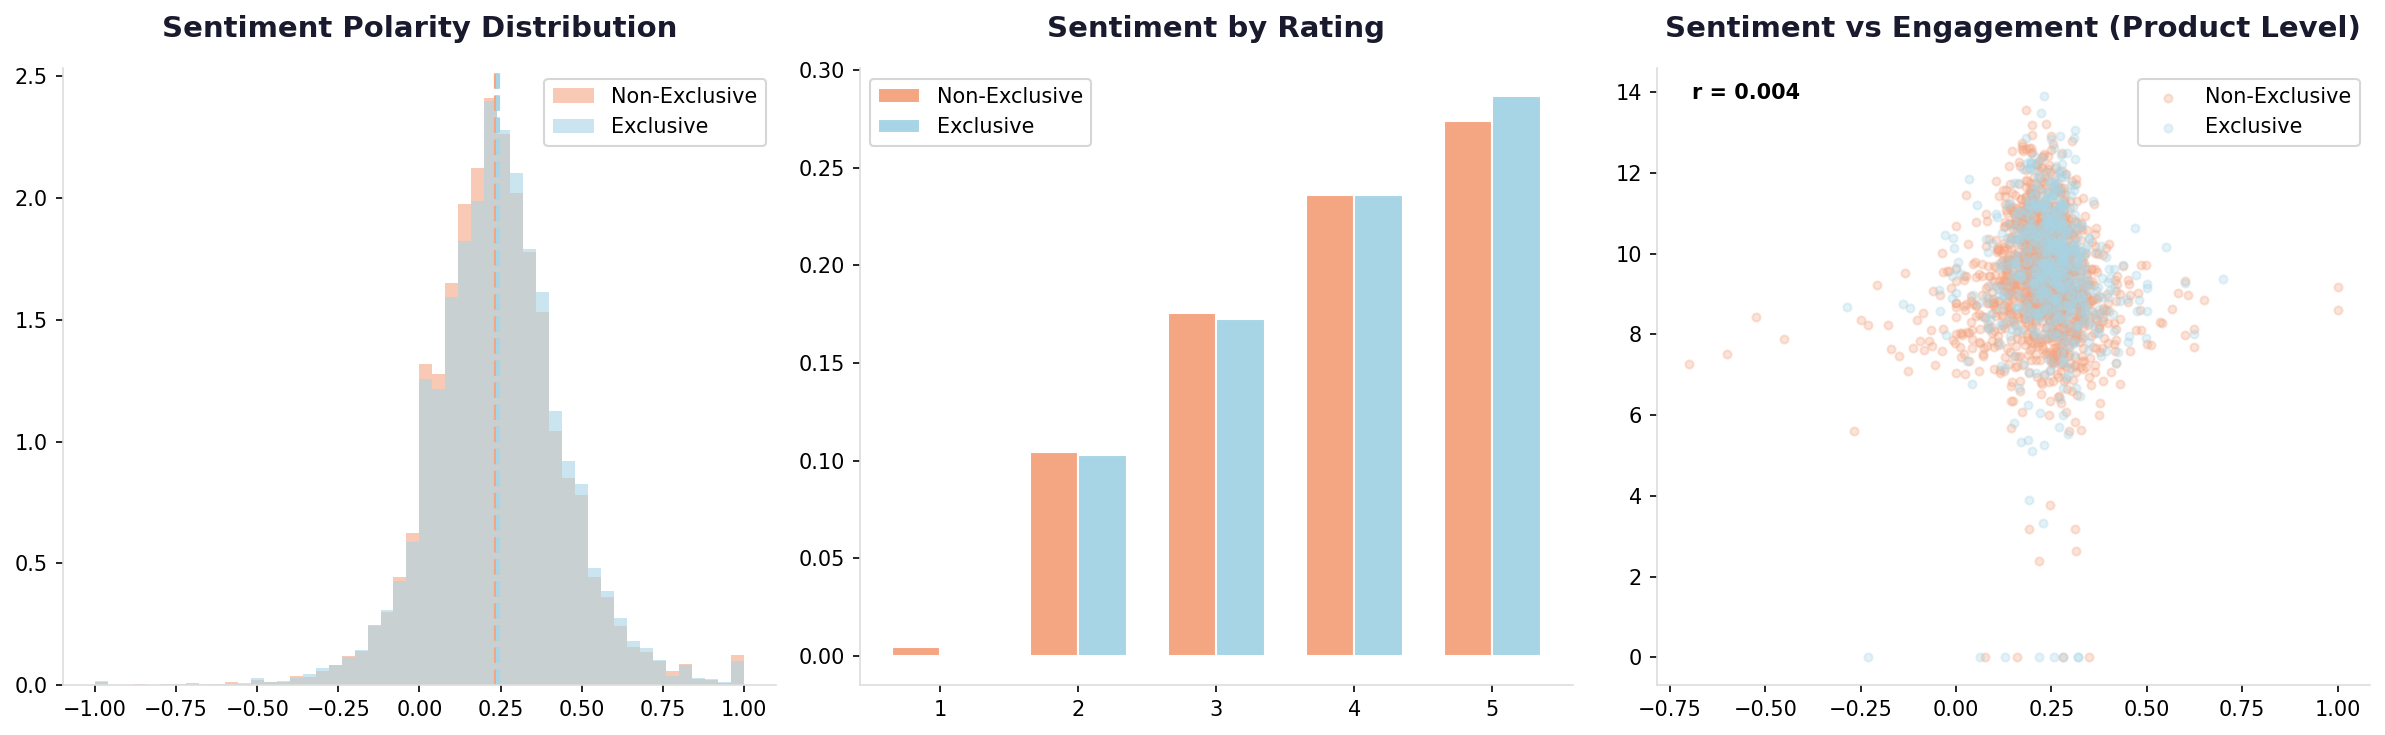

In [92]:
fig, axes = create_figure(1, 3, figsize=(16, 5))

# 1. Polarity distribution
axes[0].hist(non_excl_polarity, bins=50, alpha=0.6, label='Non-Exclusive', 
             color=EXCL_COLORS[0], density=True)
axes[0].hist(excl_polarity, bins=50, alpha=0.6, label='Exclusive', 
             color=EXCL_COLORS[1], density=True)
axes[0].axvline(x=non_excl_polarity.mean(), color=EXCL_COLORS[0], linestyle='--', linewidth=2)
axes[0].axvline(x=excl_polarity.mean(), color=EXCL_COLORS[1], linestyle='--', linewidth=2)
axes[0].set_xlabel('Sentiment Polarity', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].legend()
style_axis(axes[0], 'Sentiment Polarity Distribution', '', '')

# 2. Sentiment by star rating
sentiment_by_rating = reviews_sample.groupby(['sephora_exclusive', 'rating'])['polarity'].mean().unstack(0)
if True in sentiment_by_rating.columns and False in sentiment_by_rating.columns:
    sentiment_by_rating.columns = ['Non-Exclusive', 'Exclusive']
    
    x = np.arange(len(sentiment_by_rating))
    width = 0.35
    axes[1].bar(x - width/2, sentiment_by_rating['Non-Exclusive'], width, 
                label='Non-Exclusive', color=EXCL_COLORS[0], edgecolor='white')
    axes[1].bar(x + width/2, sentiment_by_rating['Exclusive'], width, 
                label='Exclusive', color=EXCL_COLORS[1], edgecolor='white')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([int(r) for r in sentiment_by_rating.index])
    axes[1].set_xlabel('Star Rating', fontsize=11)
    axes[1].set_ylabel('Mean Sentiment Polarity', fontsize=11)
    axes[1].legend()
    style_axis(axes[1], 'Sentiment by Rating', '', '')

# 3. Product-level: Sentiment vs Engagement
product_sentiment = reviews_sample.groupby('product_id').agg({
    'polarity': 'mean',
    'sephora_exclusive': 'first',
    'loves_count': 'first'
}).dropna()

for excl, color, label in [(False, EXCL_COLORS[0], 'Non-Exclusive'), 
                            (True, EXCL_COLORS[1], 'Exclusive')]:
    subset = product_sentiment[product_sentiment['sephora_exclusive'] == excl]
    axes[2].scatter(subset['polarity'], np.log1p(subset['loves_count']), 
                    alpha=0.3, s=15, c=color, label=label)

corr = product_sentiment['polarity'].corr(np.log1p(product_sentiment['loves_count']))
axes[2].set_xlabel('Mean Sentiment Polarity', fontsize=11)
axes[2].set_ylabel('log(Loves Count)', fontsize=11)
axes[2].legend()
axes[2].annotate(f'r = {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, fontweight='bold')
style_axis(axes[2], 'Sentiment vs Engagement (Product Level)', '', '')

plt.tight_layout()
plt.show()


The three plots reinforce this finding: (1) polarity distributions overlap almost completely, (2) sentiment tracks star ratings similarly for both groups — with ~89% of reviews being positive in both, and (3) at the product level, sentiment has near-zero correlation with engagement (r ≈ 0). Higher engagement for exclusive products is not driven by customers being happier with them.

#### 5.3 Do customers use different emotional language for exclusives?

Total emotion words: Exclusive=93,705, Non-Exclusive=189,822

Word                Exclusive   Non-Excl    Ratio
--------------------------------------------------
love                   13,311     24,804    1.09x
great                   6,257     13,268   1.05x←
good                    4,608      9,589   1.03x←
recommend               4,296      8,707   1.00x←
amazing                 4,152      7,380    1.14x
oily                    3,458      7,931   1.13x←
soft                    3,305      7,111   1.06x←
nice                    3,359      6,815   1.00x←
smooth                  3,059      6,497   1.05x←
light                   2,349      4,888   1.03x←
best                    2,009      4,484   1.10x←
hydrating               2,023      3,832    1.07x
worth                   1,710      3,904   1.13x←
perfect                 1,801      3,427    1.06x
greasy                  1,495      3,721   1.23x←


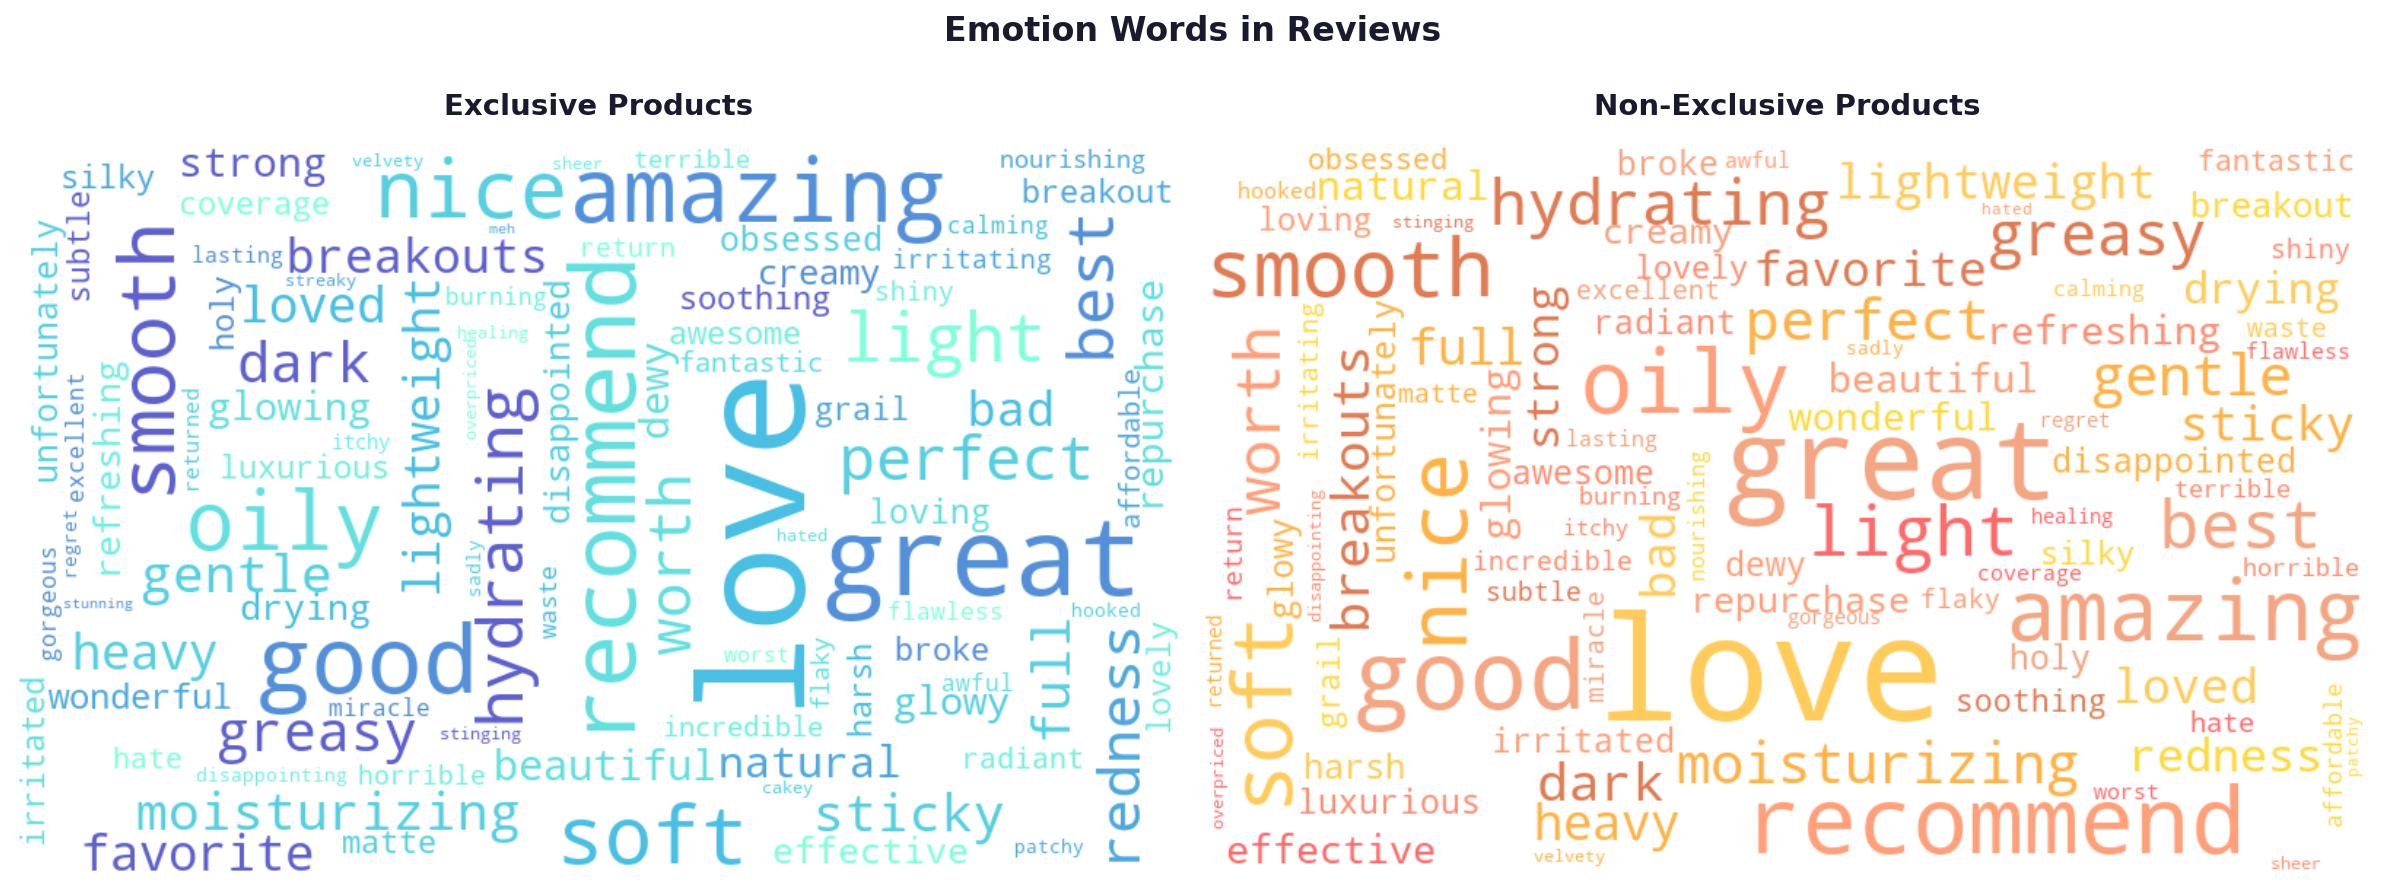

In [93]:
# Count emotion words by exclusivity
excl_emotions = Counter()
non_excl_emotions = Counter()

for _, row in reviews_sample.iterrows():
    words = extract_emotions(row['review_text'])
    if row['sephora_exclusive']:
        excl_emotions.update(words)
    else:
        non_excl_emotions.update(words)

excl_total = sum(excl_emotions.values())
non_excl_total = sum(non_excl_emotions.values())

print(f"Total emotion words: Exclusive={excl_total:,}, Non-Exclusive={non_excl_total:,}")

# Compare word frequencies
all_emotion_words = set(excl_emotions.keys()) | set(non_excl_emotions.keys())
word_comparison = []

for word in all_emotion_words:
    e_count = excl_emotions.get(word, 0)
    n_count = non_excl_emotions.get(word, 0)
    e_rate = e_count / max(excl_total, 1) * 1000
    n_rate = n_count / max(non_excl_total, 1) * 1000
    if e_rate + n_rate > 0:
        ratio = e_rate / max(n_rate, 0.001)
        word_comparison.append((word, e_count, n_count, e_rate, n_rate, ratio))

word_comparison.sort(key=lambda x: x[1] + x[2], reverse=True)

print(f"\n{'Word':<18} {'Exclusive':>10} {'Non-Excl':>10} {'Ratio':>8}")
print("-" * 50)
for word, e_count, n_count, e_rate, n_rate, ratio in word_comparison[:15]:
    ratio_str = f"{ratio:.2f}x" if ratio > 1 else f"{1/ratio:.2f}x←"
    print(f"{word:<18} {e_count:>10,} {n_count:>10,} {ratio_str:>8}")

# Sentiment summary
excl_pos = sum(excl_emotions.get(w, 0) for w in POSITIVE_WORDS)
excl_neg = sum(excl_emotions.get(w, 0) for w in NEGATIVE_WORDS)
non_pos = sum(non_excl_emotions.get(w, 0) for w in POSITIVE_WORDS)
non_neg = sum(non_excl_emotions.get(w, 0) for w in NEGATIVE_WORDS)

styled_sentiment_summary(excl_pos, excl_neg, non_pos, non_neg)

# Plotting wordclouds
# Colors for exclusive
def color_func_excl(word, font_size, position, orientation, random_state=None, **kwargs):
    return COLORS[hash(word) % len(COLORS)]

# Colors for non-exclusive 
COLORS_WARM = ["#FF6B6B", "#FF8E72", "#FFA07A", "#FFB347", "#FFCC5C", "#FFD93D", "#F4A582", "#E07B53"]

def color_func_non(word, font_size, position, orientation, random_state=None, **kwargs):
    return COLORS_WARM[hash(word) % len(COLORS_WARM)]

fig, axes = create_figure(nrows=1, ncols=2, figsize=(16, 6))

wc_excl = WordCloud(
    width=800, height=500,
    background_color='white',
    max_words=100,
    min_font_size=10,
    max_font_size=100,
    prefer_horizontal=0.7
).generate_from_frequencies(excl_emotions)

wc_non = WordCloud(
    width=800, height=500,
    background_color='white',
    max_words=100,
    min_font_size=10,
    max_font_size=100,
    prefer_horizontal=0.7
).generate_from_frequencies(non_excl_emotions)

axes[0].imshow(wc_excl.recolor(color_func=color_func_excl), interpolation='bilinear')
axes[0].axis('off')
style_axis(axes[0], title='Exclusive Products')

axes[1].imshow(wc_non.recolor(color_func=color_func_non), interpolation='bilinear')
axes[1].axis('off')
style_axis(axes[1], title='Non-Exclusive Products')

fig.suptitle('Emotion Words in Reviews', fontsize=16, fontweight='bold', color='#1a1a2e', y=1.02)

plt.tight_layout()
plt.show()

Both groups use overwhelmingly positive emotional language (~80% positive words), with nearly identical positive-to-negative ratios (4.2 vs 3.9). The top emotion words are identical for both groups: "love", "great", "good", "recommend", and "amazing" dominate the vocabulary. The +1.4 percentage point difference in positive word usage is negligible.

## **6. CLUSTERING**

Sentiment analysis showed that customers are equally satisfied with exclusive and non-exclusive products, suggesting the engagement advantage comes from visibility rather than quality. As a final check, we use clustering to see whether exclusives dominate the highest-performing product tier
We apply KMeans clustering using four features: price, loves count, rating, and reviews. We exclude `sephora_exclusive` as our goal is to discover organic product segments based on performance, then examine whether exclusives are overrepresented in high-performing clusters

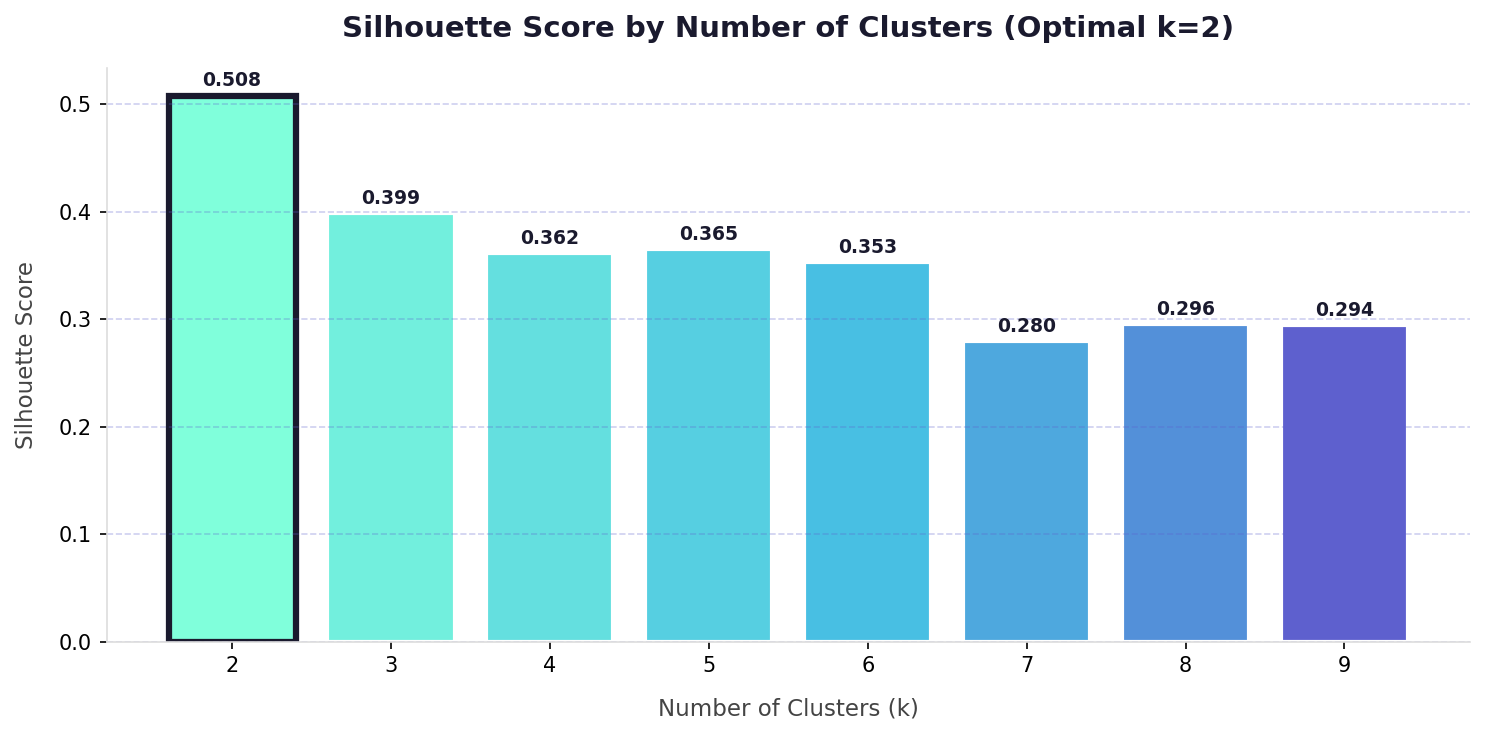

In [94]:
cluster_features = ['price_usd', 'loves_count', 'rating', 'reviews']
cluster_df = product_df.dropna(subset=cluster_features).copy()

# Remove extreme outliers
for col in ['loves_count', 'reviews', 'price_usd']:
    q99 = cluster_df[col].quantile(0.99)
    cluster_df = cluster_df[cluster_df[col] <= q99]

# Scale features
X = cluster_df[cluster_features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal k using silhouette method
k_range = range(2, 10)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot silhouette scores
fig, ax = plt.subplots(figsize=(10, 5), facecolor='#ffffff', dpi=150)
ax.set_facecolor('#ffffff')

bars = ax.bar(k_range, silhouette_scores, color=COLORS[:len(k_range)], edgecolor='white', linewidth=2)

optimal_k = k_range[np.argmax(silhouette_scores)]
bars[optimal_k - 2].set_color('#80FFDB')
bars[optimal_k - 2].set_edgecolor('#1a1a2e')
bars[optimal_k - 2].set_linewidth(3)

for bar, score in zip(bars, silhouette_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{score:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='#1a1a2e')

style_axis(ax, f'Silhouette Score by Number of Clusters (Optimal k={optimal_k})', 
           'Number of Clusters (k)', 'Silhouette Score')
ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='#5E60CE')

plt.tight_layout()
plt.show()

The silhouette method indicates **k=2** as optimal. We will therefore use `k=2` for clustering using `kmeans`

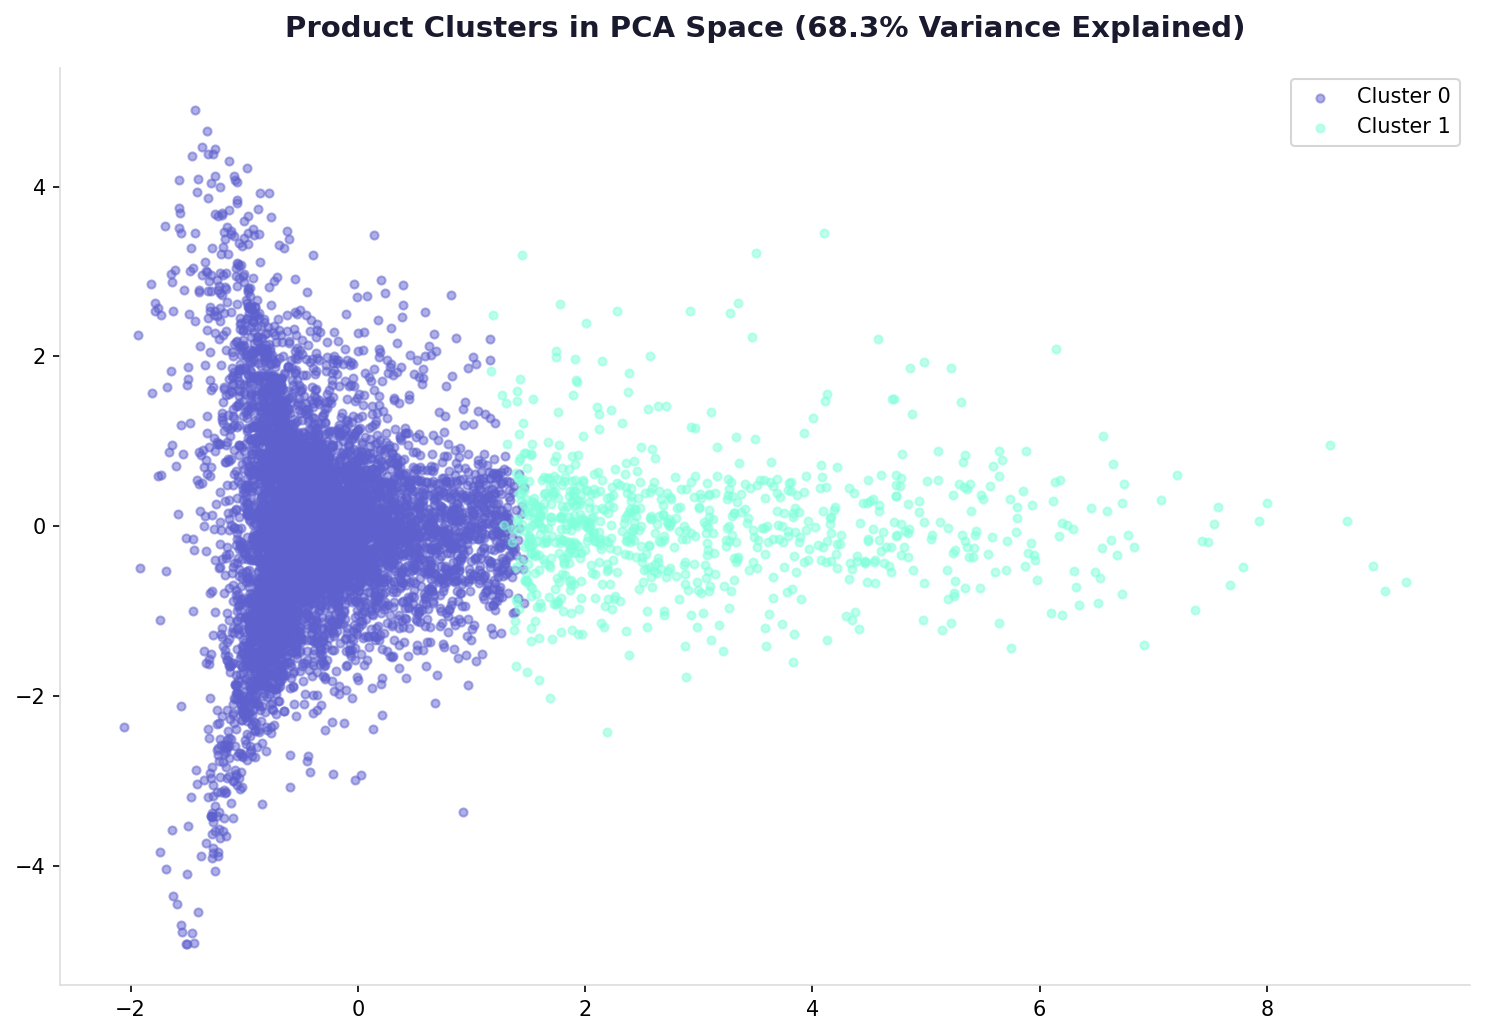

In [95]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_df['cluster'] = kmeans.fit_predict(X_scaled)

# PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

cluster_df['PC1'] = X_pca[:, 0]
cluster_df['PC2'] = X_pca[:, 1]

explained_var = pca.explained_variance_ratio_.sum() * 100

fig, ax = create_figure(1, 1, figsize=(10, 7))

colors = {'0': '#5E60CE', '1': '#80FFDB', '2': '#FF6B6B', '3': '#FFD93D', '4': '#6BCB77', '5': '#4D96FF'}

for cluster in cluster_df['cluster'].unique():
    subset = cluster_df[cluster_df['cluster'] == cluster]
    ax.scatter(subset['PC1'], subset['PC2'], c=colors.get(str(cluster), '#999'),
               label=f'Cluster {cluster}', alpha=0.5, s=15)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.legend()
style_axis(ax, f'Product Clusters in PCA Space ({explained_var:.1f}% Variance Explained)', '', '')

plt.tight_layout()
plt.show()

Since we cannot visualize 4-dimensional data directly, we use PCA to compress our 4 features into 2 principal components. The plot shows two distinct clusters with clear separation. To understand what distinguishes these clusters, we examine their summary statistics below.

In [96]:
cluster_stats = cluster_df.groupby('cluster').agg(
    n_products=('product_id', 'count'),
    avg_price=('price_usd', 'mean'),
    avg_loves=('loves_count', 'mean'),
    avg_rating=('rating', 'mean'),
    avg_reviews=('reviews', 'mean'),
    n_exclusive=('sephora_exclusive', 'sum')
).reset_index()

cluster_stats['pct_of_total'] = cluster_stats['n_products'] / cluster_stats['n_products'].sum() * 100
cluster_stats['pct_exclusive'] = cluster_stats['n_exclusive'] / cluster_stats['n_products'] * 100
cluster_stats = cluster_stats.set_index('cluster')

# Sort by average loves
cluster_stats = cluster_stats.sort_values('avg_loves', ascending=False)

styled_cluster_summary(cluster_stats)

Cluster,Products,% of Total,Avg Price,Avg Loves,Avg Rating,Avg Reviews,% Exclusive
1,820,10.3%,$41,"105,421",4.27,1604,31.3%
0,"7,152",89.7%,$49,"14,724",4.18,194,28.1%


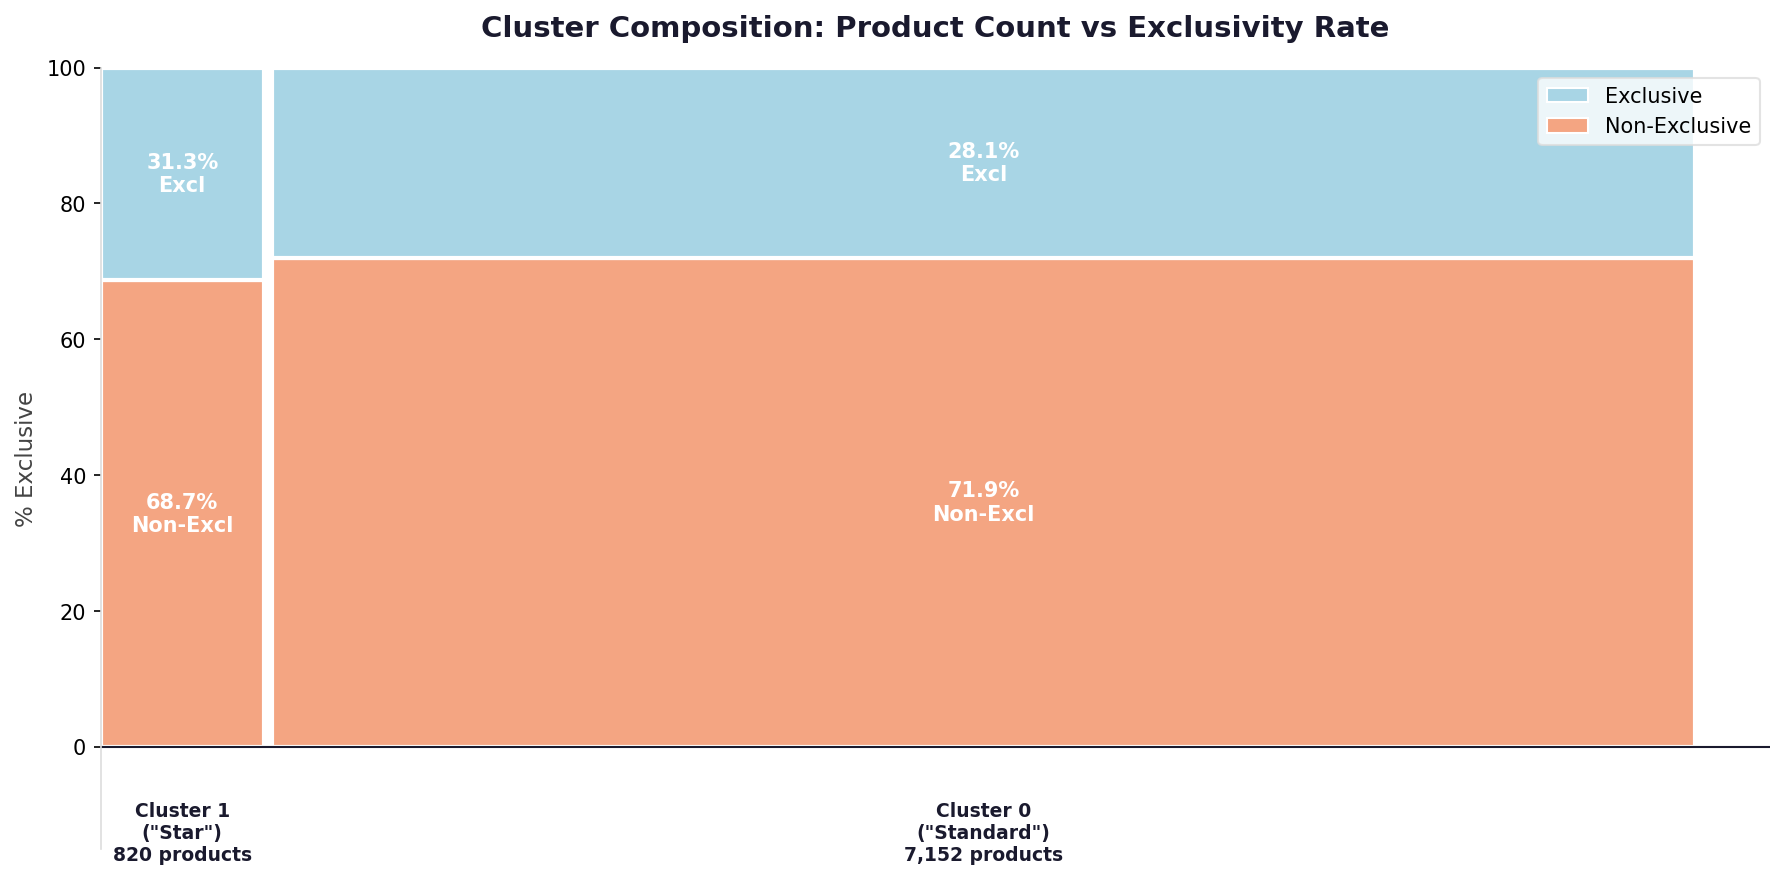

In [97]:
styled_cluster_exclusivity(cluster_stats.reset_index())

# MEKKO CHART
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#ffffff', dpi=150)
ax.set_facecolor('#ffffff')

cluster_data = cluster_stats[['n_products', 'n_exclusive', 'pct_exclusive', 'avg_loves']].copy()
cluster_data = cluster_data.sort_values('avg_loves', ascending=False)

total_products = cluster_data['n_products'].sum()
widths = cluster_data['n_products'] / total_products

x_positions = [0]
for w in widths[:-1]:
    x_positions.append(x_positions[-1] + w)

cluster_colors = {1: '#80FFDB', 0: '#5E60CE'}

for i, (cluster_idx, row) in enumerate(cluster_data.iterrows()):
    x = x_positions[i]
    width = widths.iloc[i]
    excl_pct = row['pct_exclusive']
    non_excl_pct = 100 - excl_pct
    
    # Non-exclusive portion (bottom)
    ax.bar(x, non_excl_pct, width=width * 0.95, align='edge', 
           color=EXCL_COLORS[0], edgecolor='white', linewidth=2)
    
    # Exclusive portion (top)
    ax.bar(x, excl_pct, width=width * 0.95, bottom=non_excl_pct, align='edge',
           color=EXCL_COLORS[1], edgecolor='white', linewidth=2)
    
    # Labels inside bars
    if non_excl_pct > 10:
        ax.text(x + width * 0.475, non_excl_pct / 2, f'{non_excl_pct:.1f}%\nNon-Excl', 
                ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    if excl_pct > 10:
        ax.text(x + width * 0.475, non_excl_pct + excl_pct / 2, f'{excl_pct:.1f}%\nExcl', 
                ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    
    # Cluster label below
    label = f'Cluster {int(cluster_idx)}\n("{"Star" if cluster_idx == 1 else "Standard"}")\n{int(row["n_products"]):,} products'
    ax.text(x + width * 0.475, -8, label, ha='center', va='top', fontsize=9, fontweight='bold', color='#1a1a2e')

ax.set_xlim(0, 1)
ax.set_ylim(-15, 100)
ax.set_ylabel('% Exclusive', fontsize=11, color='#444')
ax.set_xticks([])
ax.axhline(y=0, color='#1a1a2e', linewidth=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_color('#ddd')

ax.set_title('Cluster Composition: Product Count vs Exclusivity Rate', fontsize=14, fontweight='bold', color='#1a1a2e', pad=15)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=EXCL_COLORS[1], edgecolor='white', label='Exclusive'),
                   Patch(facecolor=EXCL_COLORS[0], edgecolor='white', label='Non-Exclusive')]
ax.legend(handles=legend_elements, loc='upper right', frameon=True, facecolor='white', edgecolor='#ddd')

plt.tight_layout()
plt.show()

We can infer the following about the 2 clusters:
- Cluster 1 ("star" products): 10% of the catalog with exceptional engagement (105K average loves, 1,604 reviews). 31% of products in this cluster are exclusive.
- Cluster 0 (standard products): 90% of the catalog with typical performance (15K loves, 194 reviews). 28% of products in this cluster are exclusive.

While exclusives are slightly overrepresented among star products (31% vs 28%), this 3 percentage point difference is modest. More tellingly, 89% of all exclusive products fall into the standard-engagement cluster. **Exclusivity provides a small boost but does not guarantee star status.**

## **7. CONCLUSION**

We sought to identify if Sephora's exclusivity strategy drives customer engagement. Drawing on analysis of 8,494 products and >1M customer reviews, we find consistent evidence of a **positive relationship between exclusivity and engagement**

Overall, Sephora's exclusivity strategy appears to work through **visibility and marketing** rather than product quality. The "Only at Sephora" label, combined with newness and scarcity signals, generates attention and brings customers back but the products themselves deliver similar experiences to non-exclusives. Here's how we arrived at this conclusion:

- We started by exploring the data. EDA showed that **exclusive products (~28% of Sephora's catalog) consistently outperform non-exclusives**: higher loves (9.51 vs 9.15 log-transformed), more reviews (4.77 vs 4.64 log-transformed), and marginally higher ratings (4.21 vs 4.19), all statistically significant. Notably, exclusives are cheaper than non-exclusives (mean $39 vs $56), indicating the engagement gap is not driven by premium pricing

- We then tested whether this effect holds after controlling for other factors. OLS regression confirmed that **exclusive products receive ~16.5% more loves than non-exclusives**, even after controlling for price, rating, review volume, and category. This effect is statistically robust (p < 0.001, 95% CI: 10.4%–22.9%) and stable across multiple model specifications. Logistic regression revealed that Sephora's exclusivity assignment is deliberate: exclusive products tend to be cheaper, newer, and more likely to be limited edition suggesting an integrated launch strategy rather than premium positioning

- But does higher engagement mean happier customers? Sentiment analysis found no. Customers write reviews of the same length (59.5 vs 60.9 words), express the same level of positivity (~89% positive reviews, mean polarity ~0.24), and use the same emotional vocabulary regardless of exclusivity status. The correlation between product-level sentiment and engagement was essentially zero. **Customers are not happier with exclusive products, they simply interact with them more**

- Finally, we asked: do exclusives dominate the top-performing products? Clustering analysis grouped products into high-engagement "stars" (10% of catalog) and standard performers (90%). Exclusives are modestly overrepresented among stars (31.3% vs 28.1%), but 89% of exclusive products still fall into the standard tier. **Exclusivity nudges products toward better performance but does not guarantee star status**

#### Limitations

Our findings come with limitations. We can show correlation but not causation i.e., we cannot tell whether exclusivity drives engagement or whether Sephora picks products that would perform well anyway. We also lack data on marketing budgets, store placement, and social media promotion. Additionally, our data is from 2023 and covers only Sephora's US catalog, so results may not apply to other time periods or retailers

#### Further research

Further research could track products that transition between exclusive and non-exclusive status to establish causality, compare exclusivity effects across multiple retailers, do a survey to directly inquire about how the "Only at Sephora" label influences customer purchasing decisions, or go deeper into brand analysis and look how it influences the customer engagement 

## **8. REFERENCES**

BeautyMatter. (2025). *Sephora Bets on Brand Exclusivity and Experience to Power Global Push*. Retrieved from https://beautymatter.com/articles/sephora-bets-on-brand-exclusivity-and-experience-to-power-global-push

Business Model Analyst. (2025). *Sephora Marketing Strategy*. Retrieved from https://businessmodelanalyst.com/sephora-marketing-strategy/

CB Insights. (2021). *How Sephora Built A Beauty Empire To Survive The Retail Apocalypse*. Retrieved from https://www.cbinsights.com/research/report/sephora-teardown/

Mintel. (2025). *Key Consumer Trends Shaping the Future of Luxury Retail*. Retrieved from https://www.mintel.com/insights/retail/luxury-retail-trends/

Mohan, M. & Srivastava, R.K. (2022). *Experiential marketing strategies used by luxury cosmetics companies*. ResearchGate. Retrieved from https://www.researchgate.net/publication/358458219_Experiential_marketing_strategies_used_by_luxury_cosmetics_companies

Nadyinky. (2023). *Sephora Products and Skincare Reviews* [Dataset]. Kaggle. Retrieved from https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews

NielsenIQ. (2024). *The Evolution of Beauty Retail and Why Brands May Need to Re-Think Their Go-to-Market Strategies*. Retrieved from https://nielseniq.com/global/en/insights/commentary/2024/the-evolution-of-beauty-retail-and-why-brands-may-need-to-re-think-their-go-to-market-strategies/

Waskom, M. L., (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021, https://doi.org/10.21105/joss.03021.
